In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from scipy.stats import norm
import itertools
import plotly.graph_objects as go
import pickle as pkl

In [4]:
all_data = pd.read_csv(r"Datasets/preliminary.csv", index_col=0)
all_data.index = pd.to_datetime(all_data.index)

In [5]:
evaluation_length = int(np.ceil(all_data.shape[0] * 0.1))
display(evaluation_length)

4927

In [7]:
# use ~ last six months of data for final evaluation
# holdout_test_data = all_data[all_data.index >= np.datetime64("2023-06-01")]
holdout_test_data = all_data.iloc[-evaluation_length:, :]
# remove test data from the rest of the dataset
training_data = all_data[~all_data.index.isin(holdout_test_data.index)]

In [21]:
for variable in training_data:
    fig = go.Figure()

    # Add a time series line plot
    fig.add_trace(go.Scatter(x=training_data.index, y=training_data[variable], mode='lines', name='Time Series'))

    # Customize the layout
    fig.update_layout(
        title='Time Series Plot of {}'.format(variable),
        xaxis_title='Time',
        yaxis_title='{}'.format(variable),
        template='plotly_dark'  # Use a dark theme
    )

    variable = variable.replace(r"/", "-")
    with open(r"Plotly Figures/Raw Time Series/{}.pkl".format(variable), 'wb') as file:
        pkl.dump(fig, file=file)

In [15]:
with open(r"Plotly Figures/Raw Time Series/test.pkl", 'rb') as file:
    fig = pkl.load(file=file)

fig.show()

In [22]:
def detect_outliers(data:pd.Series, n:int=1000, p:float=0.001):
    """
    Detect outliers in a time series using a moving average estimation model.

    Parameters:
    - data: Time series data.
    - n: Window size for the moving average (default: 1000).
    - p: Initial threshold probability (default: 0.001).

    Returns:
    - outliers: Boolean array indicating whether each data point is an outlier.
    """

    # define array to hold boolean identifications
    outliers = np.zeros_like(data, dtype=bool)
    if n is None: n = int(np.ceil(data.shape[0] * 0.01))
    half_n = n // 2 # define upper and lower window sizes

    for i in range(half_n, len(data) - half_n):
        window = data[i - half_n : i + half_n + 1] # define window
        mean = np.mean(window)
        std_dev = np.std(window)
            
        z_score = (data[i] - mean) / std_dev
        probability = norm.cdf(z_score) # calculate probability of generating sample from points around it

        # check if sample is highly unlikely to be generated from the same distribution as the points around it
        if (probability >= (1 - p/2)) or (probability <= p/2):
            outliers[i] = True

    return outliers

In [32]:
# Plot the time series with outliers marked
outliers_removed = training_data.copy()
for variable in training_data:
    ts = training_data[variable].copy()
    outliers = detect_outliers(ts, p=0.001, n=1000)
    outliers_removed.loc[outliers, variable] = np.nan # replace outliers with NAN to remove them
    outliers = ts[outliers]

    fig = go.Figure()

    # Add a time series line plot
    fig.add_trace(go.Scatter(x=ts.index, y=ts, mode='lines', name='Time Series'))
    fig.add_trace(go.Scatter(x=outliers.index, y=outliers, mode='markers', name='Outliers'))

    # Customize the layout
    fig.update_layout(
        title='Time Series Plot of {}'.format(variable),
        xaxis_title='Time',
        yaxis_title='{}'.format(variable),
        template='plotly_dark'  # Use a dark theme
    )

    variable = variable.replace(r"/", "-")
    with open(r"Plotly Figures/Outlier Detection/{}.pkl".format(variable), 'wb') as file:
        pkl.dump(fig, file=file)

1000


/tmp/ipykernel_14965/3959371739.py:25: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


/tmp/ipykernel_14965/3959371739.py:25: RuntimeWarning:

invalid value encountered in scalar divide



1000
1000
1000
1000
1000
1000
1000


In [33]:
# don't want to apply outlier detection to HourlyPrecipitation since it behaves more like a binary variable than a normally distributed one.

# Define bin edges and labels
bins = [-float('inf'), 0.0001, 0.05, 0.33, float('inf')]
labels = ['None', 'Light Rain', 'Medium Rain', 'Heavy Rain']

# Bin the 'values' column
outliers_removed.loc[:, "HourlyPrecipitation"] = pd.cut(training_data['HourlyPrecipitation'], bins=bins, labels=labels)

In [ ]:
# fill HourlyPrecipitation missing values with "None"

Find best fitting Prophet model for each variable

In [34]:
# get total number of periods available for training and cross validation
display(outliers_removed.shape[0])

# want to use five cross validation windows
num_cvs = 5
horizon_hours = (outliers_removed.shape[0]/2) // num_cvs
initial_hours = outliers_removed.shape[0] - (horizon_hours*num_cvs)
display(initial_hours)

44340

22170.0

In [35]:
variable = "Energy Demand (MWH)"

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# df_cv = cross_validation(model, initial=f'{initial_hours} hours', horizon=f'{horizon_hours} hours', parallel="processes")
df = outliers_removed[[variable]].reset_index().rename(columns={"index":"ds", variable:"y"})

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(model, initial=f'{initial_hours} hours', horizon=f'{horizon_hours} hours', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    print("{}: {}".format(str(params), df_p['rmse']))

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

19:40:17 - cmdstanpy - INFO - Chain [1] start processing
19:40:19 - cmdstanpy - INFO - Chain [1] done processing
19:40:21 - cmdstanpy - INFO - Chain [1] start processing
19:40:21 - cmdstanpy - INFO - Chain [1] start processing
19:40:21 - cmdstanpy - INFO - Chain [1] start processing
19:40:22 - cmdstanpy - INFO - Chain [1] start processing
19:40:22 - cmdstanpy - INFO - Chain [1] start processing
19:40:22 - cmdstanpy - INFO - Chain [1] start processing
19:40:22 - cmdstanpy - INFO - Chain [1] start processing
19:40:22 - cmdstanpy - INFO - Chain [1] start processing
19:40:26 - cmdstanpy - INFO - Chain [1] done processing
19:40:28 - cmdstanpy - INFO - Chain [1] done processing
19:40:29 - cmdstanpy - INFO - Chain [1] done processing
19:40:30 - cmdstanpy - INFO - Chain [1] done processing
19:40:30 - cmdstanpy - INFO - Chain [1] done processing
19:40:30 - cmdstanpy - INFO - Chain [1] done processing
19:40:31 - cmdstanpy - INFO - Chain [1] done processing
19:40:31 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}: 0    579.679802
Name: rmse, dtype: float64


19:40:34 - cmdstanpy - INFO - Chain [1] start processing
19:40:36 - cmdstanpy - INFO - Chain [1] done processing
19:40:39 - cmdstanpy - INFO - Chain [1] start processing
19:40:39 - cmdstanpy - INFO - Chain [1] start processing
19:40:39 - cmdstanpy - INFO - Chain [1] start processing
19:40:39 - cmdstanpy - INFO - Chain [1] start processing
19:40:39 - cmdstanpy - INFO - Chain [1] start processing
19:40:39 - cmdstanpy - INFO - Chain [1] start processing
19:40:39 - cmdstanpy - INFO - Chain [1] start processing
19:40:40 - cmdstanpy - INFO - Chain [1] start processing
19:40:45 - cmdstanpy - INFO - Chain [1] done processing
19:40:46 - cmdstanpy - INFO - Chain [1] done processing
19:40:47 - cmdstanpy - INFO - Chain [1] done processing
19:40:49 - cmdstanpy - INFO - Chain [1] done processing
19:40:49 - cmdstanpy - INFO - Chain [1] done processing
19:40:50 - cmdstanpy - INFO - Chain [1] done processing
19:40:50 - cmdstanpy - INFO - Chain [1] done processing
19:40:50 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}: 0    581.007489
Name: rmse, dtype: float64


19:40:53 - cmdstanpy - INFO - Chain [1] start processing
19:40:56 - cmdstanpy - INFO - Chain [1] done processing
19:40:57 - cmdstanpy - INFO - Chain [1] start processing
19:40:58 - cmdstanpy - INFO - Chain [1] start processing
19:40:58 - cmdstanpy - INFO - Chain [1] start processing
19:40:58 - cmdstanpy - INFO - Chain [1] start processing
19:40:58 - cmdstanpy - INFO - Chain [1] start processing
19:40:58 - cmdstanpy - INFO - Chain [1] start processing
19:40:59 - cmdstanpy - INFO - Chain [1] start processing
19:40:59 - cmdstanpy - INFO - Chain [1] start processing
19:41:04 - cmdstanpy - INFO - Chain [1] done processing
19:41:05 - cmdstanpy - INFO - Chain [1] done processing
19:41:05 - cmdstanpy - INFO - Chain [1] done processing
19:41:05 - cmdstanpy - INFO - Chain [1] done processing
19:41:06 - cmdstanpy - INFO - Chain [1] done processing
19:41:06 - cmdstanpy - INFO - Chain [1] done processing
19:41:06 - cmdstanpy - INFO - Chain [1] done processing
19:41:08 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}: 0    580.079622
Name: rmse, dtype: float64


19:41:11 - cmdstanpy - INFO - Chain [1] start processing
19:41:14 - cmdstanpy - INFO - Chain [1] done processing
19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:17 - cmdstanpy - INFO - Chain [1] start processing
19:41:20 - cmdstanpy - INFO - Chain [1] done processing
19:41:24 - cmdstanpy - INFO - Chain [1] done processing
19:41:26 - cmdstanpy - INFO - Chain [1] done processing
19:41:27 - cmdstanpy - INFO - Chain [1] done processing
19:41:28 - cmdstanpy - INFO - Chain [1] done processing
19:41:28 - cmdstanpy - INFO - Chain [1] done processing
19:41:28 - cmdstanpy - INFO - Chain [1] done processing
19:41:31 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}: 0    580.452488
Name: rmse, dtype: float64


19:41:33 - cmdstanpy - INFO - Chain [1] start processing
19:41:43 - cmdstanpy - INFO - Chain [1] done processing
19:41:45 - cmdstanpy - INFO - Chain [1] start processing
19:41:46 - cmdstanpy - INFO - Chain [1] start processing
19:41:46 - cmdstanpy - INFO - Chain [1] start processing
19:41:46 - cmdstanpy - INFO - Chain [1] start processing
19:41:46 - cmdstanpy - INFO - Chain [1] start processing
19:41:46 - cmdstanpy - INFO - Chain [1] start processing
19:41:46 - cmdstanpy - INFO - Chain [1] start processing
19:41:46 - cmdstanpy - INFO - Chain [1] start processing
19:42:04 - cmdstanpy - INFO - Chain [1] done processing
19:42:05 - cmdstanpy - INFO - Chain [1] done processing
19:42:06 - cmdstanpy - INFO - Chain [1] done processing
19:42:08 - cmdstanpy - INFO - Chain [1] done processing
19:42:08 - cmdstanpy - INFO - Chain [1] done processing
19:42:08 - cmdstanpy - INFO - Chain [1] done processing
19:42:09 - cmdstanpy - INFO - Chain [1] done processing
19:42:11 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}: 0    589.017035
Name: rmse, dtype: float64


19:42:14 - cmdstanpy - INFO - Chain [1] start processing
19:42:21 - cmdstanpy - INFO - Chain [1] done processing
19:42:23 - cmdstanpy - INFO - Chain [1] start processing
19:42:23 - cmdstanpy - INFO - Chain [1] start processing
19:42:24 - cmdstanpy - INFO - Chain [1] start processing
19:42:24 - cmdstanpy - INFO - Chain [1] start processing
19:42:24 - cmdstanpy - INFO - Chain [1] start processing
19:42:24 - cmdstanpy - INFO - Chain [1] start processing
19:42:24 - cmdstanpy - INFO - Chain [1] start processing
19:42:25 - cmdstanpy - INFO - Chain [1] start processing
19:42:44 - cmdstanpy - INFO - Chain [1] done processing
19:42:45 - cmdstanpy - INFO - Chain [1] done processing
19:42:46 - cmdstanpy - INFO - Chain [1] done processing
19:42:48 - cmdstanpy - INFO - Chain [1] done processing
19:42:50 - cmdstanpy - INFO - Chain [1] done processing
19:42:51 - cmdstanpy - INFO - Chain [1] done processing
19:42:51 - cmdstanpy - INFO - Chain [1] done processing
19:42:53 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}: 0    586.939851
Name: rmse, dtype: float64


19:42:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:03 - cmdstanpy - INFO - Chain [1] done processing
19:43:05 - cmdstanpy - INFO - Chain [1] start processing
19:43:05 - cmdstanpy - INFO - Chain [1] start processing
19:43:06 - cmdstanpy - INFO - Chain [1] start processing
19:43:06 - cmdstanpy - INFO - Chain [1] start processing
19:43:06 - cmdstanpy - INFO - Chain [1] start processing
19:43:06 - cmdstanpy - INFO - Chain [1] start processing
19:43:06 - cmdstanpy - INFO - Chain [1] start processing
19:43:06 - cmdstanpy - INFO - Chain [1] start processing
19:43:24 - cmdstanpy - INFO - Chain [1] done processing
19:43:24 - cmdstanpy - INFO - Chain [1] done processing
19:43:27 - cmdstanpy - INFO - Chain [1] done processing
19:43:28 - cmdstanpy - INFO - Chain [1] done processing
19:43:29 - cmdstanpy - INFO - Chain [1] done processing
19:43:31 - cmdstanpy - INFO - Chain [1] done processing
19:43:31 - cmdstanpy - INFO - Chain [1] done processing
19:43:33 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}: 0    587.524955
Name: rmse, dtype: float64


19:43:35 - cmdstanpy - INFO - Chain [1] start processing
19:43:47 - cmdstanpy - INFO - Chain [1] done processing
19:43:49 - cmdstanpy - INFO - Chain [1] start processing
19:43:49 - cmdstanpy - INFO - Chain [1] start processing
19:43:49 - cmdstanpy - INFO - Chain [1] start processing
19:43:50 - cmdstanpy - INFO - Chain [1] start processing
19:43:50 - cmdstanpy - INFO - Chain [1] start processing
19:43:50 - cmdstanpy - INFO - Chain [1] start processing
19:43:50 - cmdstanpy - INFO - Chain [1] start processing
19:43:50 - cmdstanpy - INFO - Chain [1] start processing
19:44:11 - cmdstanpy - INFO - Chain [1] done processing
19:44:11 - cmdstanpy - INFO - Chain [1] done processing
19:44:12 - cmdstanpy - INFO - Chain [1] done processing
19:44:14 - cmdstanpy - INFO - Chain [1] done processing
19:44:14 - cmdstanpy - INFO - Chain [1] done processing
19:44:15 - cmdstanpy - INFO - Chain [1] done processing
19:44:15 - cmdstanpy - INFO - Chain [1] done processing
19:44:18 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}: 0    588.23599
Name: rmse, dtype: float64


19:44:21 - cmdstanpy - INFO - Chain [1] start processing
19:44:33 - cmdstanpy - INFO - Chain [1] done processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:44:35 - cmdstanpy - INFO - Chain [1] start processing
19:45:33 - cmdstanpy - INFO - Chain [1] done processing
19:45:37 - cmdstanpy - INFO - Chain [1] done processing
19:45:37 - cmdstanpy - INFO - Chain [1] done processing
19:45:39 - cmdstanpy - INFO - Chain [1] done processing
19:45:43 - cmdstanpy - INFO - Chain [1] done processing
19:45:46 - cmdstanpy - INFO - Chain [1] done processing
19:45:47 - cmdstanpy - INFO - Chain [1] done processing
19:45:47 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}: 0    831.833115
Name: rmse, dtype: float64


19:45:50 - cmdstanpy - INFO - Chain [1] start processing
19:46:02 - cmdstanpy - INFO - Chain [1] done processing
19:46:04 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:05 - cmdstanpy - INFO - Chain [1] start processing
19:46:29 - cmdstanpy - INFO - Chain [1] done processing
19:47:05 - cmdstanpy - INFO - Chain [1] done processing
19:47:07 - cmdstanpy - INFO - Chain [1] done processing
19:47:09 - cmdstanpy - INFO - Chain [1] done processing
19:47:10 - cmdstanpy - INFO - Chain [1] done processing
19:47:15 - cmdstanpy - INFO - Chain [1] done processing
19:47:17 - cmdstanpy - INFO - Chain [1] done processing
19:47:20 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}: 0    794.179284
Name: rmse, dtype: float64


19:47:22 - cmdstanpy - INFO - Chain [1] start processing
19:47:36 - cmdstanpy - INFO - Chain [1] done processing
19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:47:38 - cmdstanpy - INFO - Chain [1] start processing
19:48:28 - cmdstanpy - INFO - Chain [1] done processing
19:48:42 - cmdstanpy - INFO - Chain [1] done processing
19:48:46 - cmdstanpy - INFO - Chain [1] done processing
19:48:48 - cmdstanpy - INFO - Chain [1] done processing
19:48:51 - cmdstanpy - INFO - Chain [1] done processing
19:48:51 - cmdstanpy - INFO - Chain [1] done processing
19:48:53 - cmdstanpy - INFO - Chain [1] done processing
19:48:54 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}: 0    803.24439
Name: rmse, dtype: float64


19:48:57 - cmdstanpy - INFO - Chain [1] start processing
19:49:10 - cmdstanpy - INFO - Chain [1] done processing
19:49:12 - cmdstanpy - INFO - Chain [1] start processing
19:49:13 - cmdstanpy - INFO - Chain [1] start processing
19:49:13 - cmdstanpy - INFO - Chain [1] start processing
19:49:13 - cmdstanpy - INFO - Chain [1] start processing
19:49:13 - cmdstanpy - INFO - Chain [1] start processing
19:49:13 - cmdstanpy - INFO - Chain [1] start processing
19:49:13 - cmdstanpy - INFO - Chain [1] start processing
19:49:13 - cmdstanpy - INFO - Chain [1] start processing
19:50:15 - cmdstanpy - INFO - Chain [1] done processing
19:50:16 - cmdstanpy - INFO - Chain [1] done processing
19:50:18 - cmdstanpy - INFO - Chain [1] done processing
19:50:20 - cmdstanpy - INFO - Chain [1] done processing
19:50:24 - cmdstanpy - INFO - Chain [1] done processing
19:50:25 - cmdstanpy - INFO - Chain [1] done processing
19:50:25 - cmdstanpy - INFO - Chain [1] done processing
19:50:26 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}: 0    794.367746
Name: rmse, dtype: float64


19:50:29 - cmdstanpy - INFO - Chain [1] start processing
19:50:45 - cmdstanpy - INFO - Chain [1] done processing
19:50:47 - cmdstanpy - INFO - Chain [1] start processing
19:50:48 - cmdstanpy - INFO - Chain [1] start processing
19:50:48 - cmdstanpy - INFO - Chain [1] start processing
19:50:48 - cmdstanpy - INFO - Chain [1] start processing
19:50:48 - cmdstanpy - INFO - Chain [1] start processing
19:50:48 - cmdstanpy - INFO - Chain [1] start processing
19:50:48 - cmdstanpy - INFO - Chain [1] start processing
19:50:48 - cmdstanpy - INFO - Chain [1] start processing
19:51:46 - cmdstanpy - INFO - Chain [1] done processing
19:51:47 - cmdstanpy - INFO - Chain [1] done processing
19:51:50 - cmdstanpy - INFO - Chain [1] done processing
19:51:57 - cmdstanpy - INFO - Chain [1] done processing
19:52:06 - cmdstanpy - INFO - Chain [1] done processing
19:52:11 - cmdstanpy - INFO - Chain [1] done processing
19:52:12 - cmdstanpy - INFO - Chain [1] done processing
19:52:13 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}: 0    1077.554929
Name: rmse, dtype: float64


19:52:15 - cmdstanpy - INFO - Chain [1] start processing
19:52:28 - cmdstanpy - INFO - Chain [1] done processing
19:52:30 - cmdstanpy - INFO - Chain [1] start processing
19:52:30 - cmdstanpy - INFO - Chain [1] start processing
19:52:31 - cmdstanpy - INFO - Chain [1] start processing
19:52:31 - cmdstanpy - INFO - Chain [1] start processing
19:52:31 - cmdstanpy - INFO - Chain [1] start processing
19:52:31 - cmdstanpy - INFO - Chain [1] start processing
19:52:31 - cmdstanpy - INFO - Chain [1] start processing
19:52:31 - cmdstanpy - INFO - Chain [1] start processing
19:53:39 - cmdstanpy - INFO - Chain [1] done processing
19:53:39 - cmdstanpy - INFO - Chain [1] done processing
19:53:46 - cmdstanpy - INFO - Chain [1] done processing
19:53:49 - cmdstanpy - INFO - Chain [1] done processing
19:53:49 - cmdstanpy - INFO - Chain [1] done processing
19:53:51 - cmdstanpy - INFO - Chain [1] done processing
19:53:56 - cmdstanpy - INFO - Chain [1] done processing
19:53:58 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}: 0    931.180637
Name: rmse, dtype: float64


19:54:00 - cmdstanpy - INFO - Chain [1] start processing
19:54:16 - cmdstanpy - INFO - Chain [1] done processing
19:54:18 - cmdstanpy - INFO - Chain [1] start processing
19:54:18 - cmdstanpy - INFO - Chain [1] start processing
19:54:18 - cmdstanpy - INFO - Chain [1] start processing
19:54:19 - cmdstanpy - INFO - Chain [1] start processing
19:54:19 - cmdstanpy - INFO - Chain [1] start processing
19:54:19 - cmdstanpy - INFO - Chain [1] start processing
19:54:19 - cmdstanpy - INFO - Chain [1] start processing
19:54:19 - cmdstanpy - INFO - Chain [1] start processing
19:55:08 - cmdstanpy - INFO - Chain [1] done processing
19:55:11 - cmdstanpy - INFO - Chain [1] done processing
19:55:22 - cmdstanpy - INFO - Chain [1] done processing
19:55:24 - cmdstanpy - INFO - Chain [1] done processing
19:55:27 - cmdstanpy - INFO - Chain [1] done processing
19:55:32 - cmdstanpy - INFO - Chain [1] done processing
19:55:34 - cmdstanpy - INFO - Chain [1] done processing
19:55:35 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}: 0    902.514461
Name: rmse, dtype: float64


19:55:37 - cmdstanpy - INFO - Chain [1] start processing
19:55:53 - cmdstanpy - INFO - Chain [1] done processing
19:55:55 - cmdstanpy - INFO - Chain [1] start processing
19:55:55 - cmdstanpy - INFO - Chain [1] start processing
19:55:55 - cmdstanpy - INFO - Chain [1] start processing
19:55:55 - cmdstanpy - INFO - Chain [1] start processing
19:55:56 - cmdstanpy - INFO - Chain [1] start processing
19:55:56 - cmdstanpy - INFO - Chain [1] start processing
19:55:56 - cmdstanpy - INFO - Chain [1] start processing
19:55:56 - cmdstanpy - INFO - Chain [1] start processing
19:56:41 - cmdstanpy - INFO - Chain [1] done processing
19:56:56 - cmdstanpy - INFO - Chain [1] done processing
19:57:06 - cmdstanpy - INFO - Chain [1] done processing
19:57:13 - cmdstanpy - INFO - Chain [1] done processing
19:57:21 - cmdstanpy - INFO - Chain [1] done processing
19:57:23 - cmdstanpy - INFO - Chain [1] done processing
19:57:24 - cmdstanpy - INFO - Chain [1] done processing
19:57:27 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}: 0    902.009477
Name: rmse, dtype: float64
    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01   579.679802
1                     0.001                     0.10   581.007489
2                     0.001                     1.00   580.079622
3                     0.001                    10.00   580.452488
4                     0.010                     0.01   589.017035
5                     0.010                     0.10   586.939851
6                     0.010                     1.00   587.524955
7                     0.010                    10.00   588.235990
8                     0.100                     0.01   831.833115
9                     0.100                     0.10   794.179284
10                    0.100                     1.00   803.244390
11                    0.100                    10.00   794.367746
12                    0.500     

Use Prophet model to impute missing values for each variable

In [36]:
prophet_models = {}
interpolations = {}
clean_data = outliers_removed.copy()
for variable in [x for x in clean_data.columns if x not in ["HourlyPrecipitation"]]:
    print(f"Interpolating for variable {variable}")
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True, 
        changepoint_prior_scale=0.001, seasonality_prior_scale=0.01)
    df = outliers_removed[[variable]].reset_index().rename(columns={"index":"ds", variable:"y"})
    results = model.fit(df)
    prophet_models[variable] = model
    interpolated_values = model.predict(df)
    interpolations[variable] = interpolated_values
    to_impute = outliers_removed[variable].isna().values
    clean_data.loc[to_impute, variable] = interpolated_values["yhat"][to_impute].values

Interpolating for variable Energy Demand (MWH)


21:02:53 - cmdstanpy - INFO - Chain [1] start processing
21:02:56 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyDewPointTemperature


21:03:01 - cmdstanpy - INFO - Chain [1] start processing
21:03:03 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyDryBulbTemperature


21:03:08 - cmdstanpy - INFO - Chain [1] start processing
21:03:11 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyRelativeHumidity


21:03:16 - cmdstanpy - INFO - Chain [1] start processing
21:03:18 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyStationPressure


21:03:24 - cmdstanpy - INFO - Chain [1] start processing
21:03:26 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyWetBulbTemperature


21:03:31 - cmdstanpy - INFO - Chain [1] start processing
21:03:34 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyWindSpeed


21:03:39 - cmdstanpy - INFO - Chain [1] start processing
21:03:41 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Energy Price (cents/KWH)


21:03:47 - cmdstanpy - INFO - Chain [1] start processing
21:03:58 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable CPI-U


21:04:03 - cmdstanpy - INFO - Chain [1] start processing
21:04:25 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Unemployment Rate


21:04:31 - cmdstanpy - INFO - Chain [1] start processing
21:04:44 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Unemployment Level


21:04:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:12 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Employment Level


21:05:18 - cmdstanpy - INFO - Chain [1] start processing
21:05:33 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Labor Force Level


21:05:38 - cmdstanpy - INFO - Chain [1] start processing
21:05:58 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Employment Population Ratio


21:06:03 - cmdstanpy - INFO - Chain [1] start processing
21:06:17 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Labor Force Participation


21:06:22 - cmdstanpy - INFO - Chain [1] start processing
21:06:42 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Civilian Noninstitutional Population


21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:07:05 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Payroll Employment


21:07:10 - cmdstanpy - INFO - Chain [1] start processing
21:07:24 - cmdstanpy - INFO - Chain [1] done processing


Visualize variable distributions and decompositions

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-

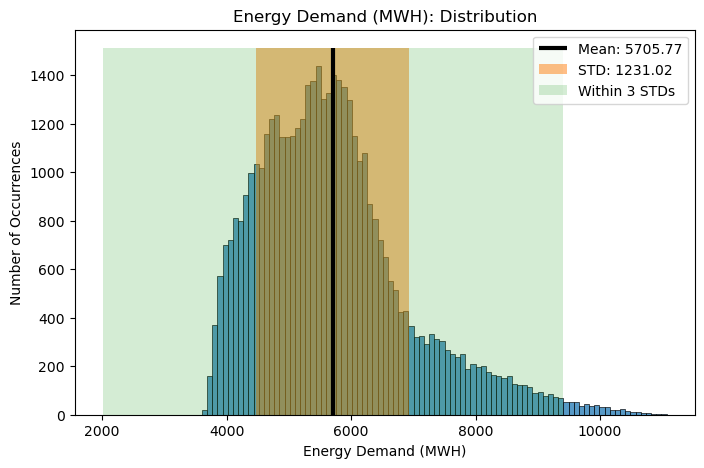

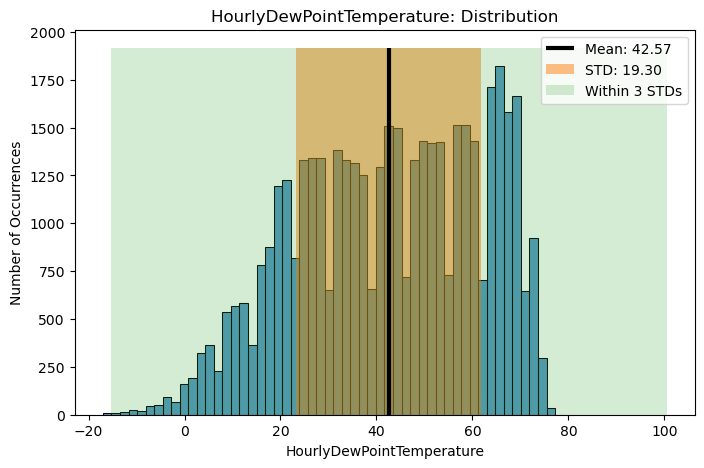

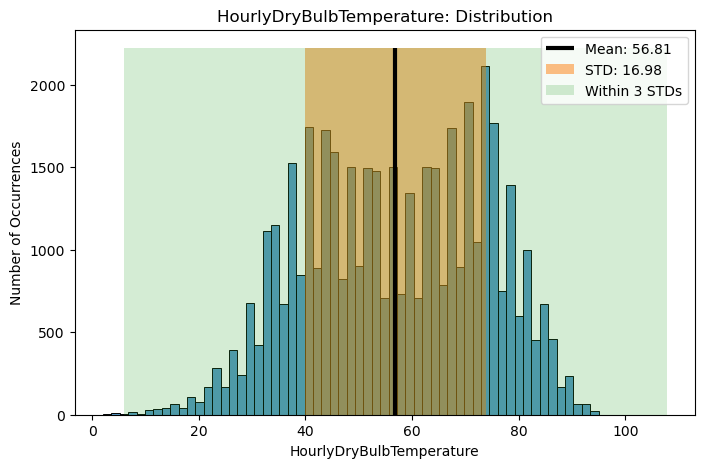

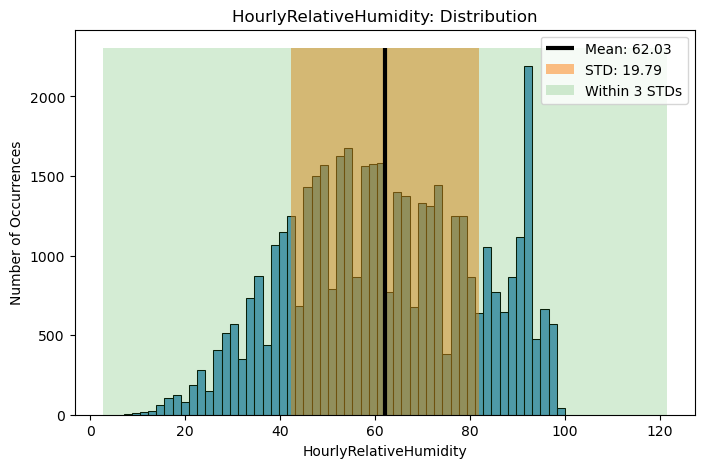

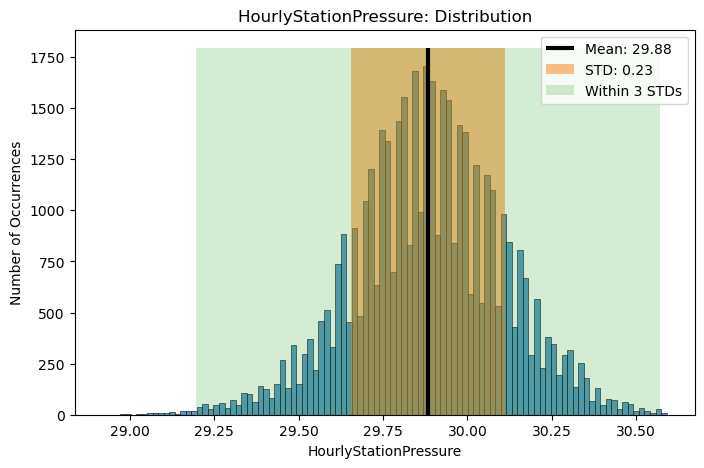

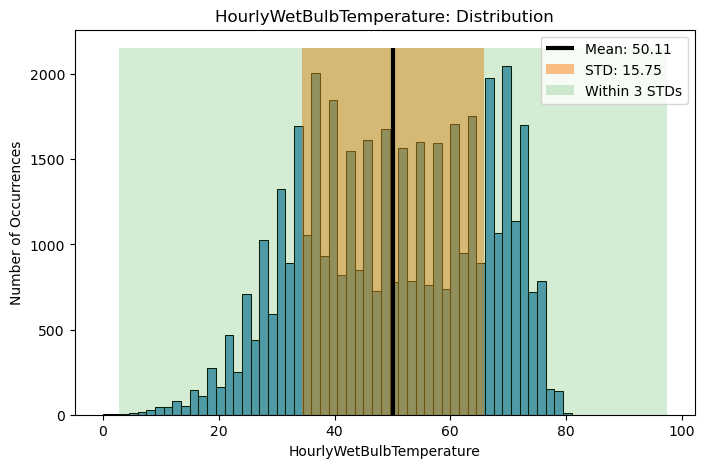

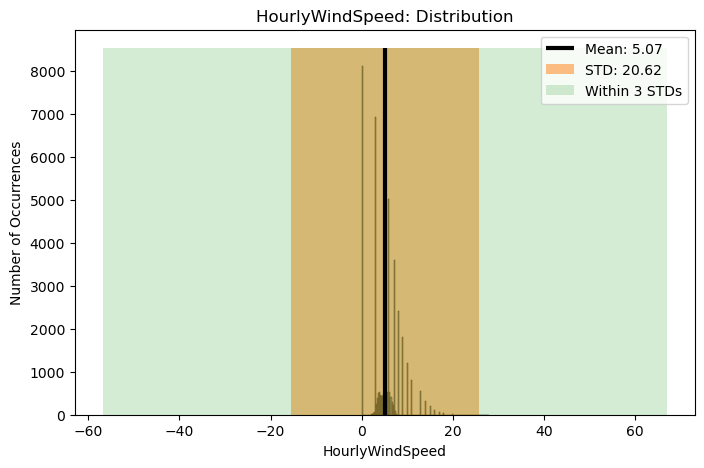

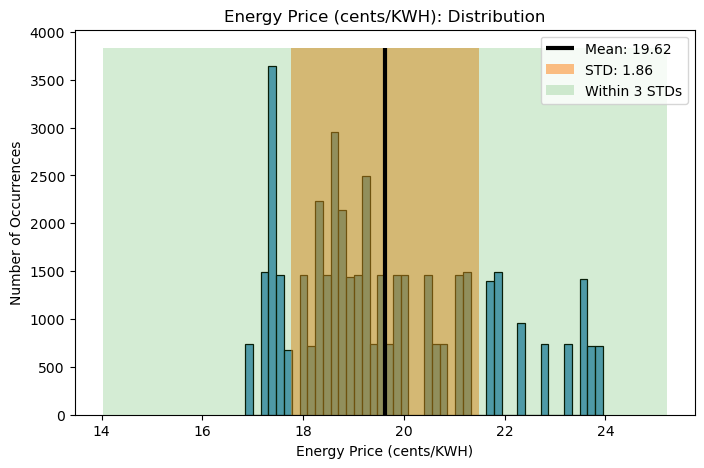

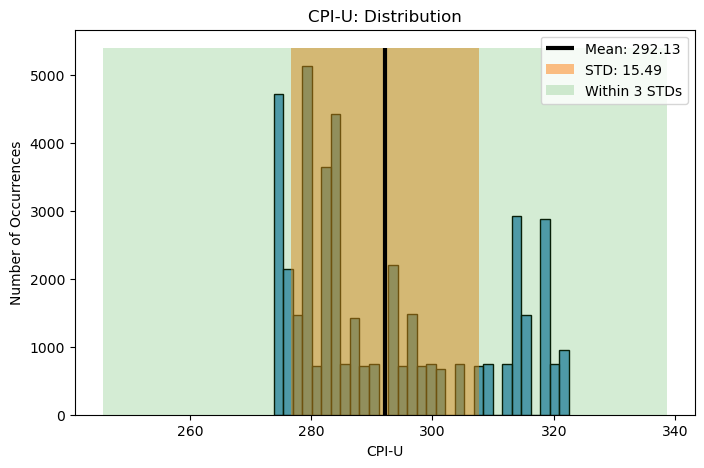

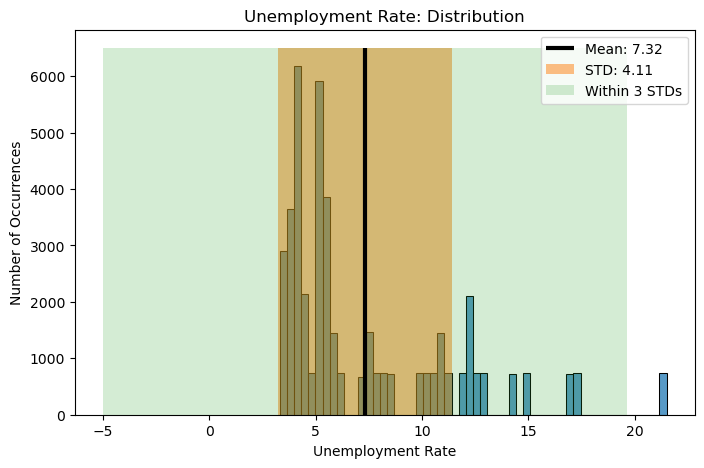

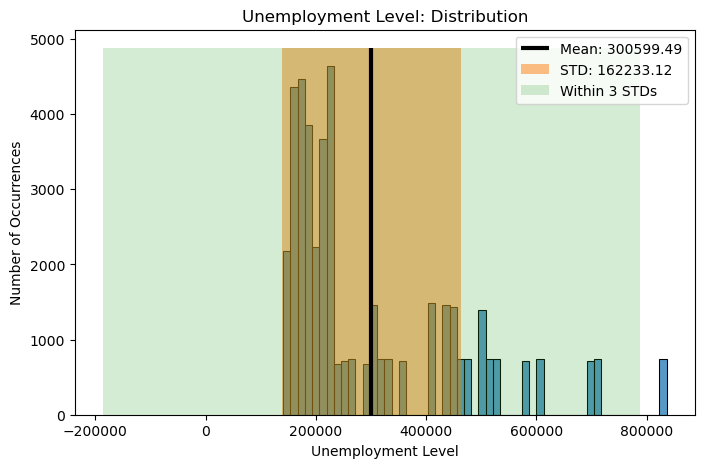

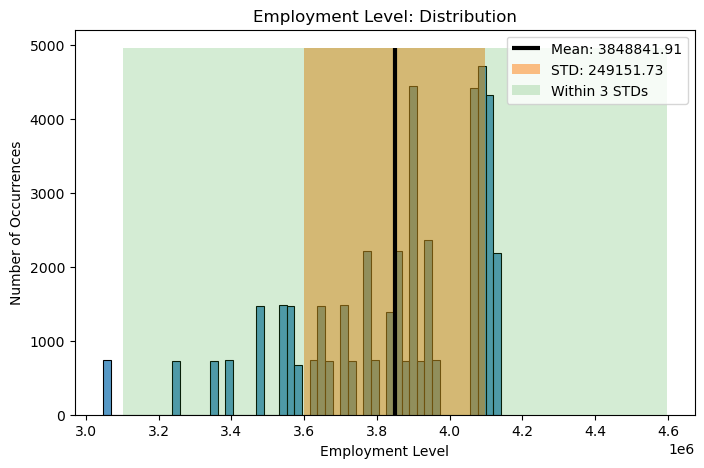

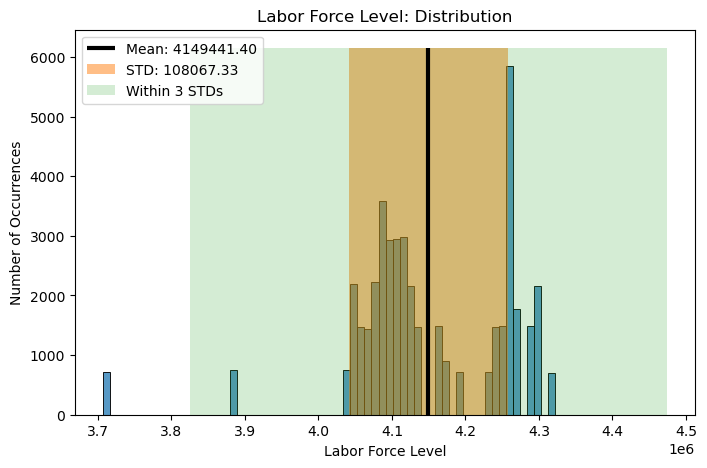

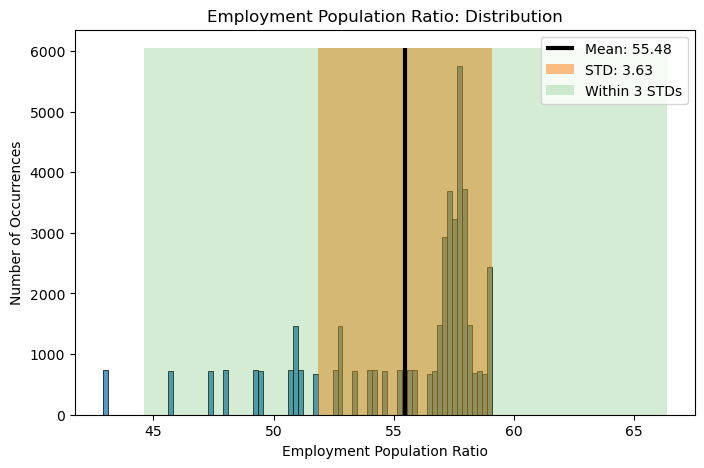

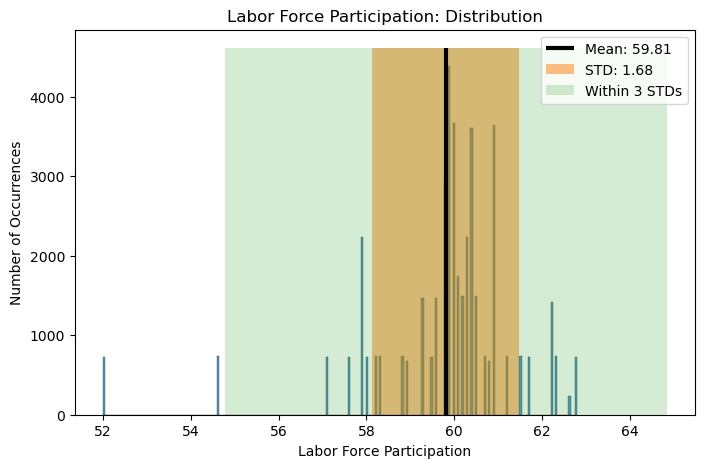

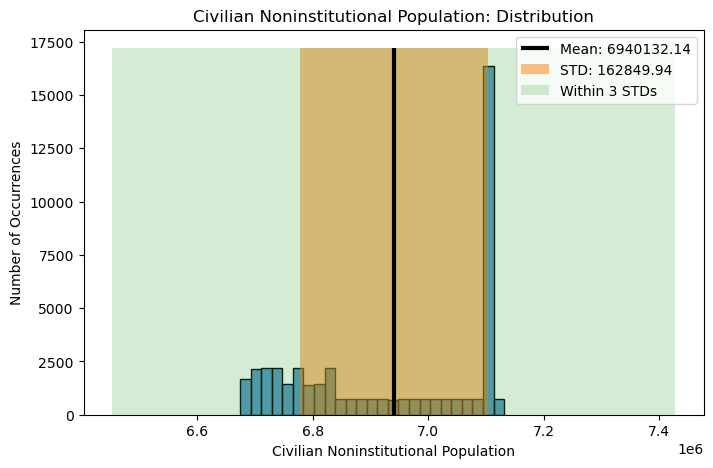

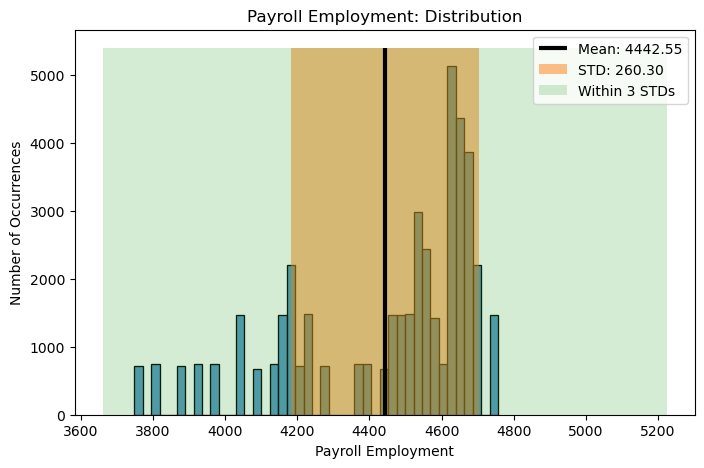

In [37]:
for variable in [x for x in clean_data.columns if x not in ["HourlyPrecipitation"]]:
    # calculate mean and standard deviation
    mean = training_data[variable].mean()
    std = training_data[variable].std()
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot()
    sns.histplot(clean_data[variable])
    ax.set_title(f"{variable}: Distribution")
    ax.set_xlabel(variable)
    ax.set_ylabel("Number of Occurrences")
    ylim = ax.get_ylim()
    ax.vlines(x=mean, ymin=ylim[0], ymax=ylim[1], color="black", linewidth=3, label="Mean: {:.2f}".format(mean))
    ax.fill_between(x=[mean-std, mean+std], y1=ylim[0], y2=ylim[1], alpha=0.5, label="STD: {:.2f}".format(std))
    ax.fill_between(x=[mean-3*std, mean+3*std], y1=ylim[0], y2=ylim[1], alpha=0.2, label="Within 3 STDs".format(std))
    ax.legend()

In [38]:
display(clean_data["HourlyPrecipitation"].value_counts())

HourlyPrecipitation
None           37349
Light Rain      2276
Medium Rain     1097
Heavy Rain       114
Name: count, dtype: int64

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



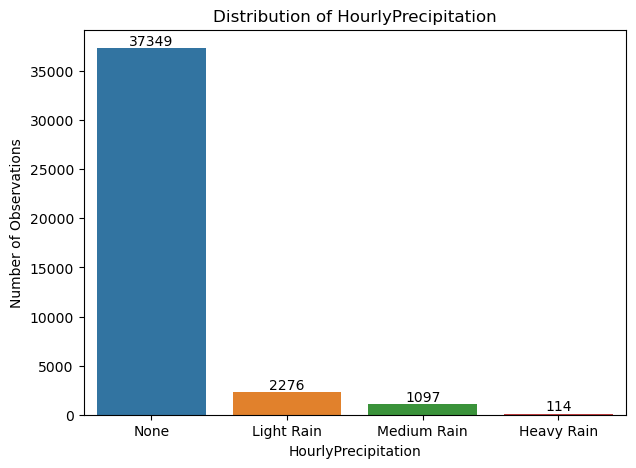

In [39]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot()
sns.countplot(x=clean_data["HourlyPrecipitation"])
ax.set_title("Distribution of HourlyPrecipitation")
ax.bar_label(ax.containers[0])
ax.set_ylabel("Number of Observations")
plt.show()

### Basic Time Series Plots

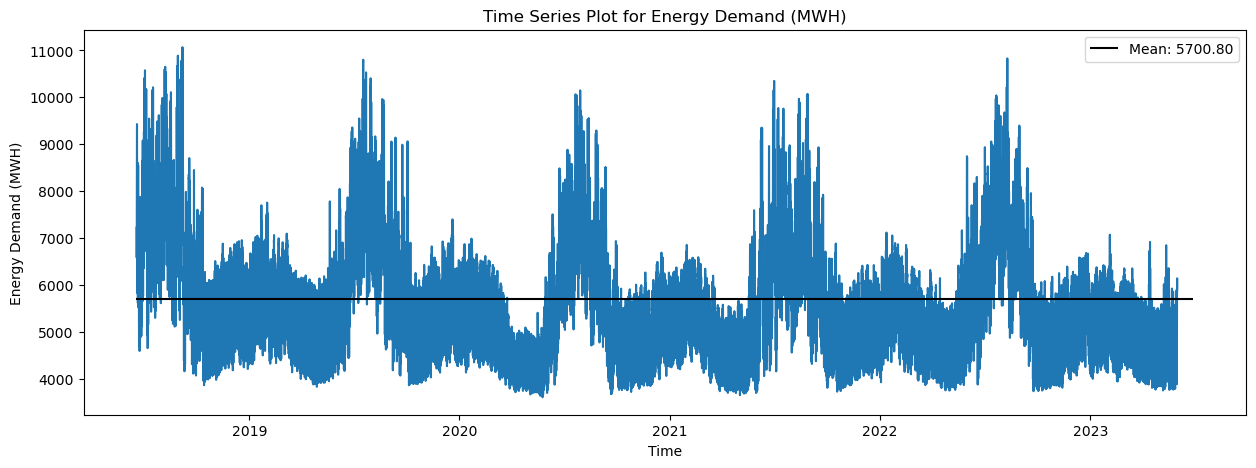

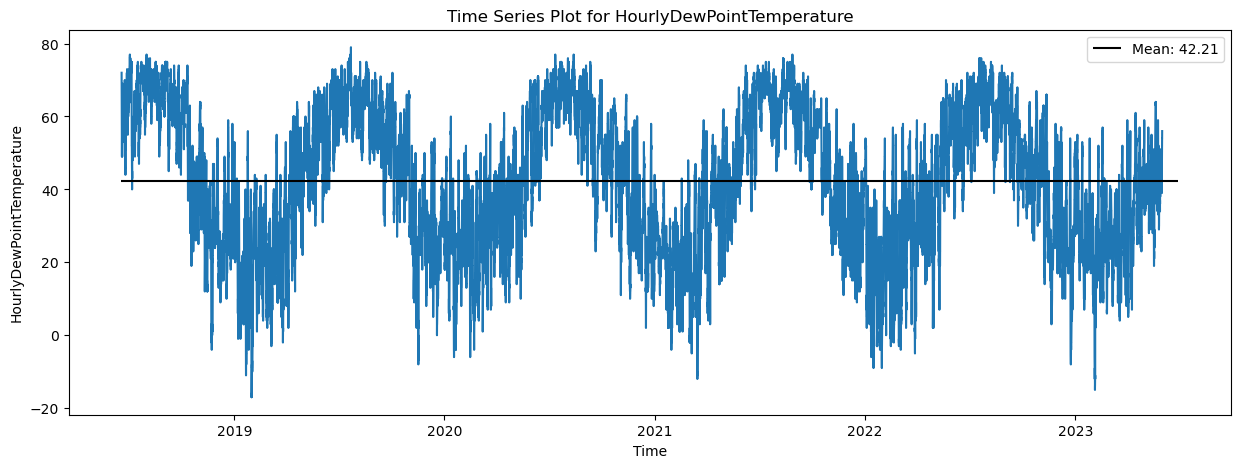

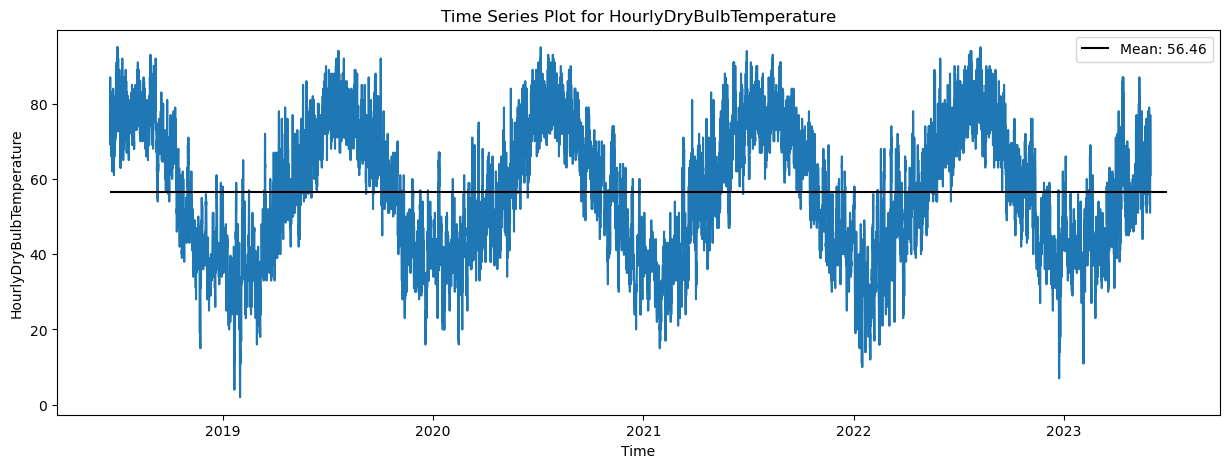

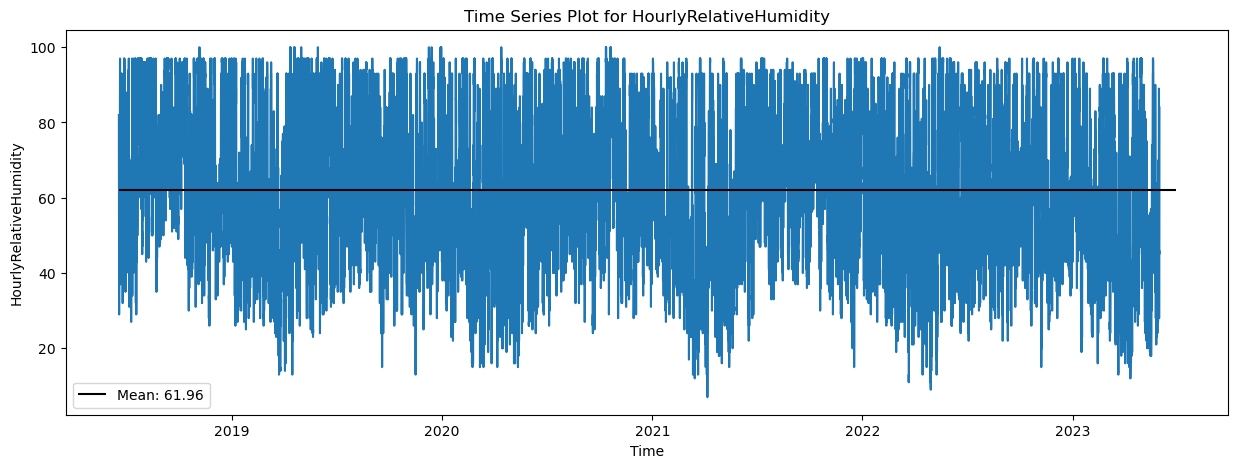

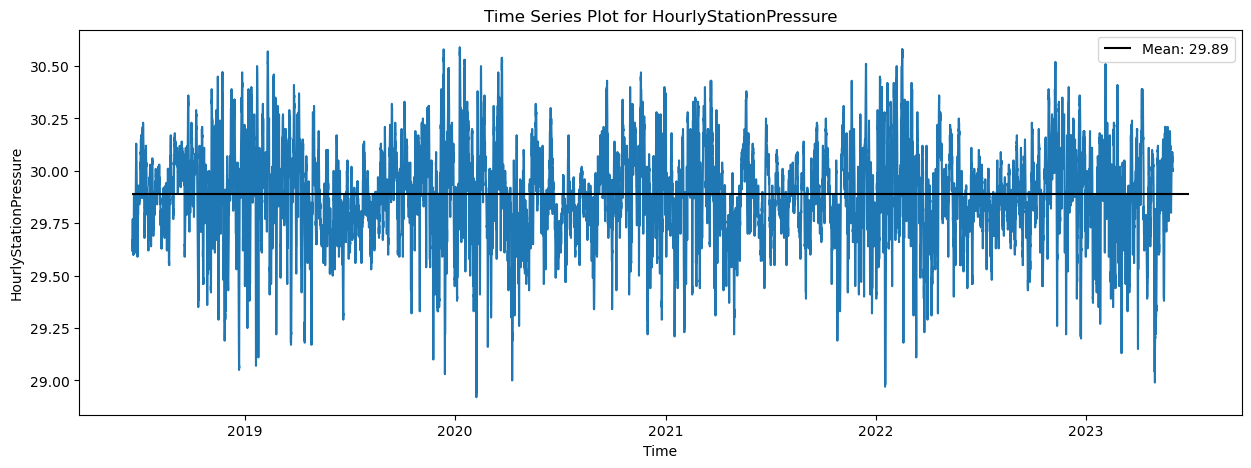

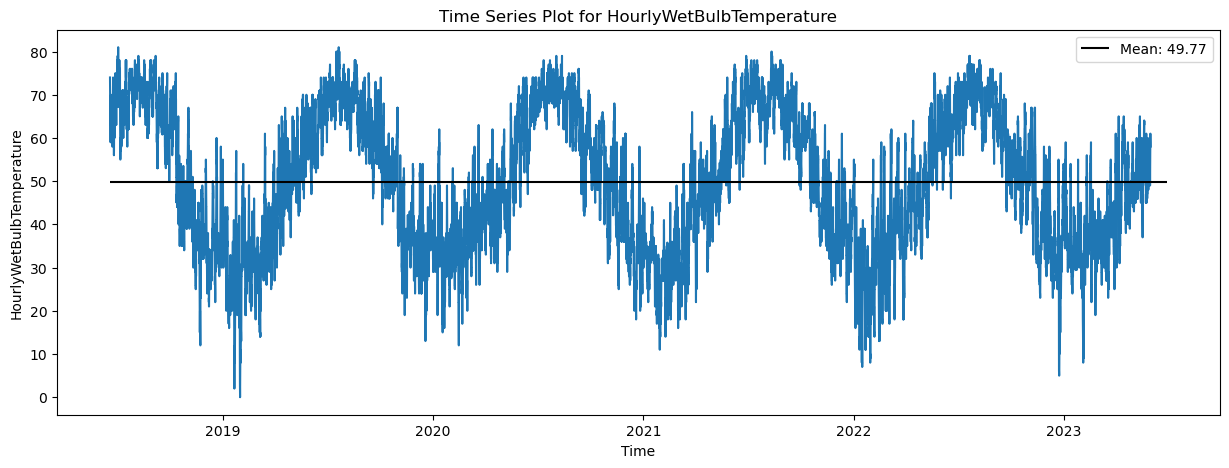

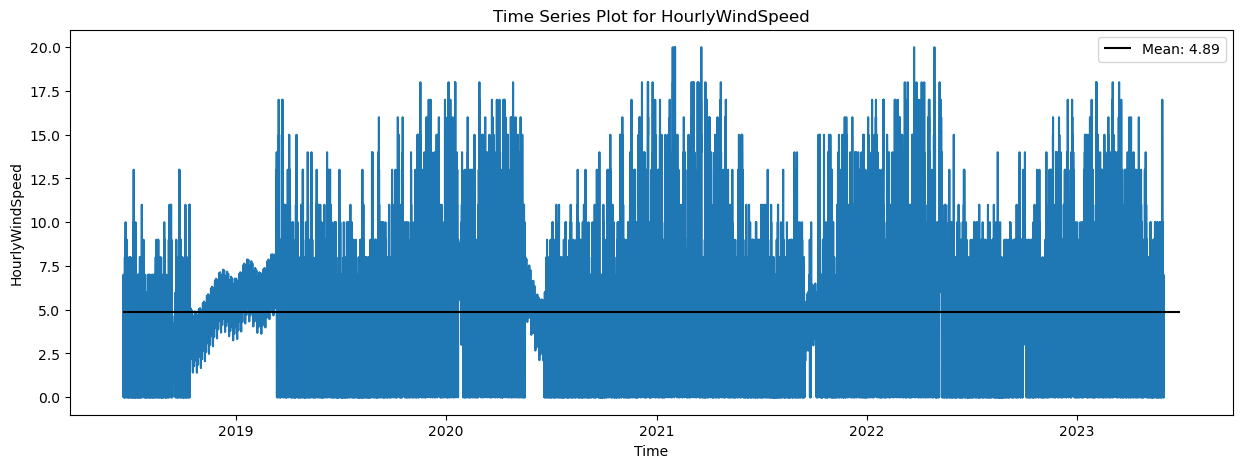

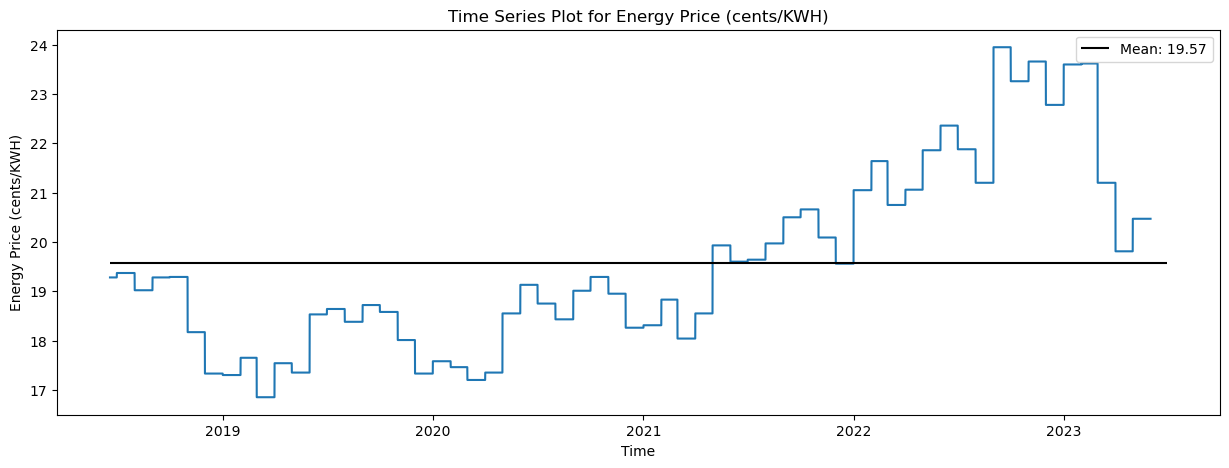

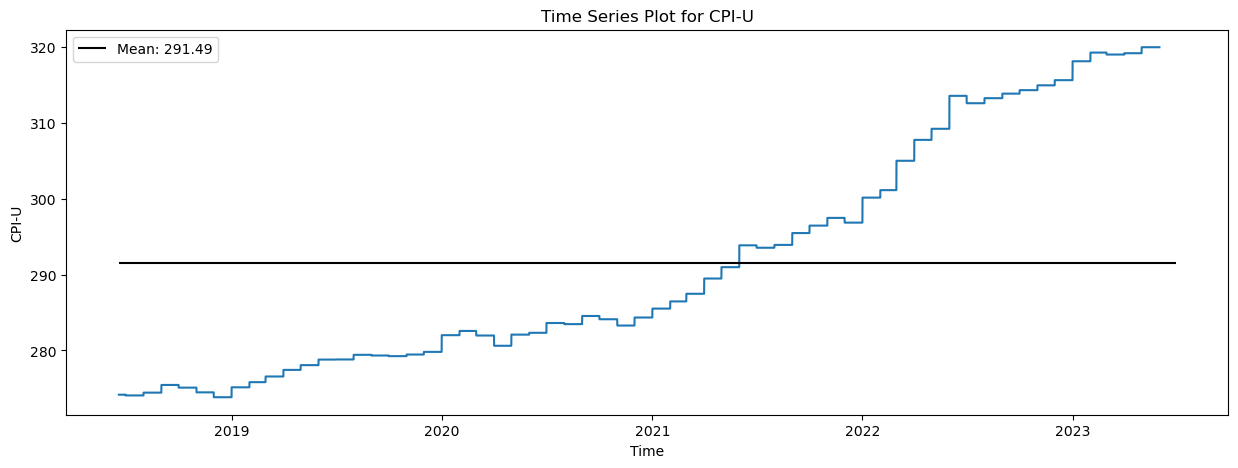

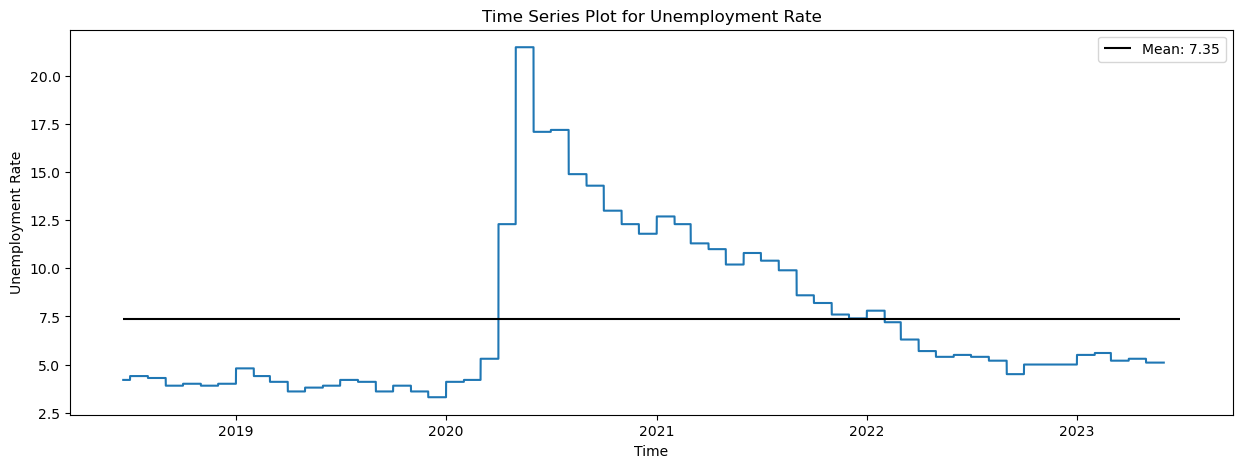

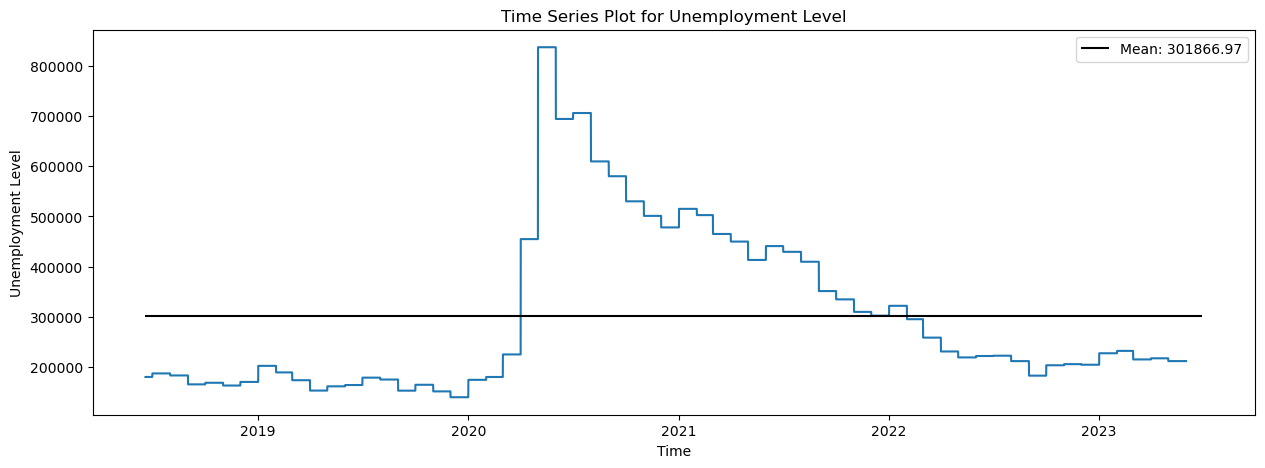

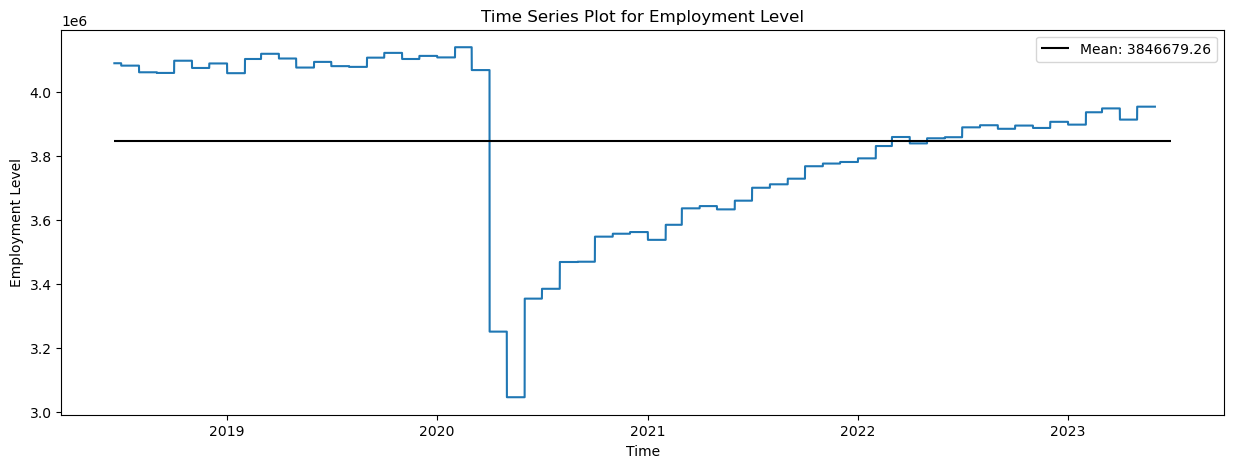

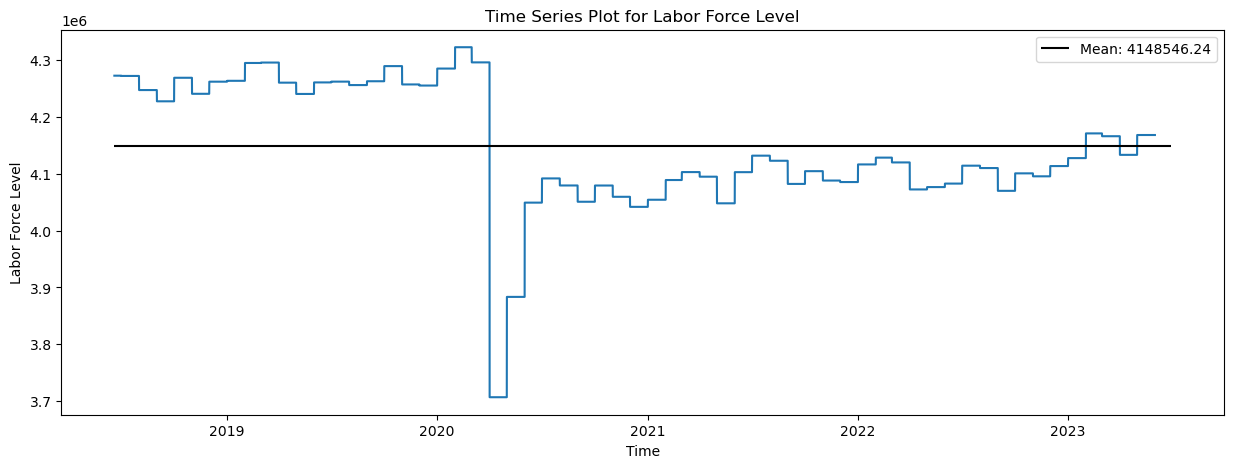

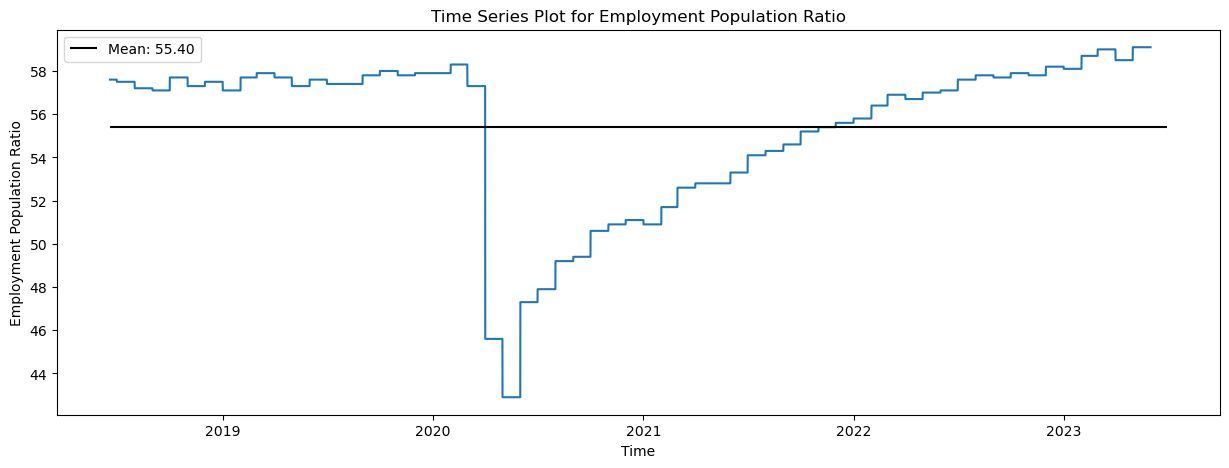

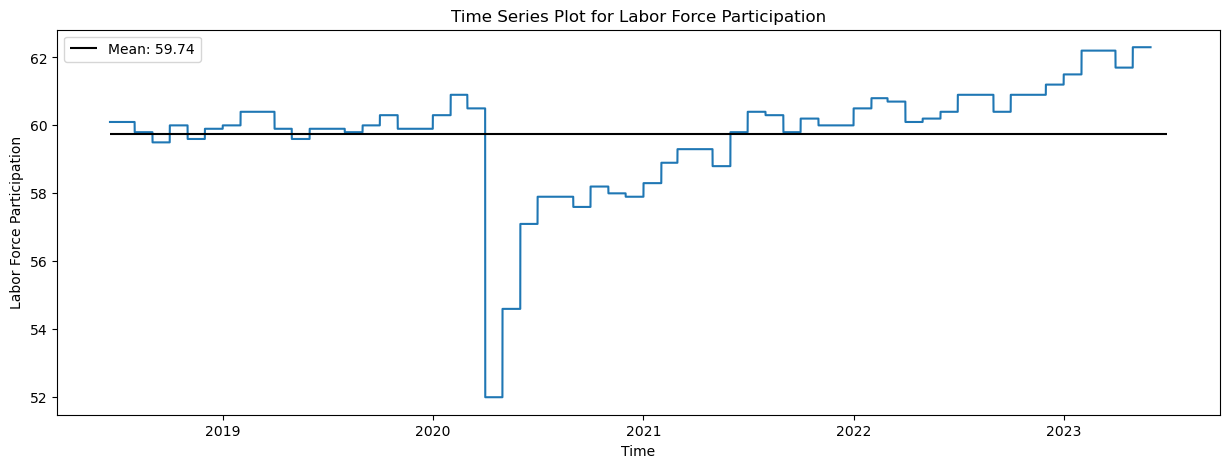

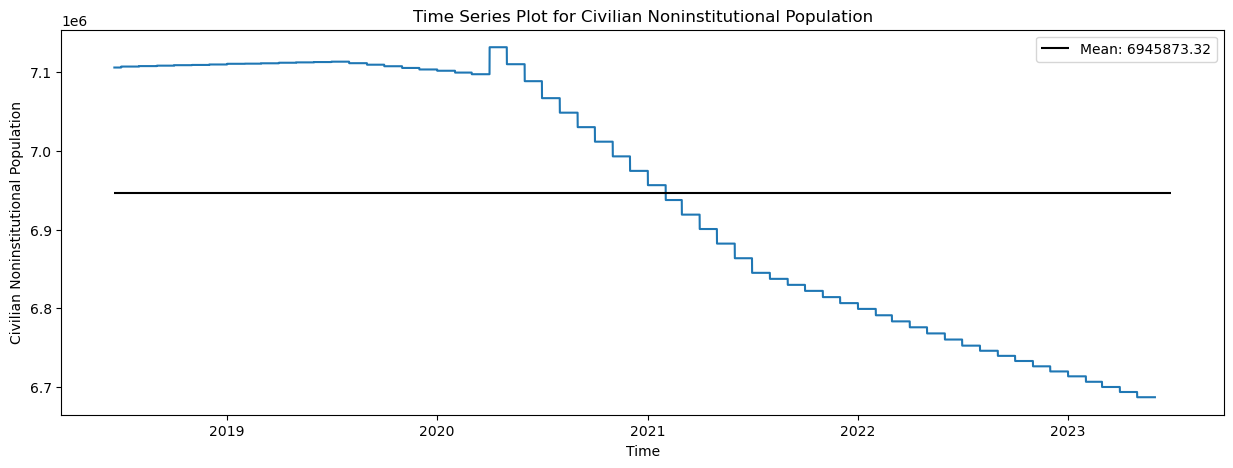

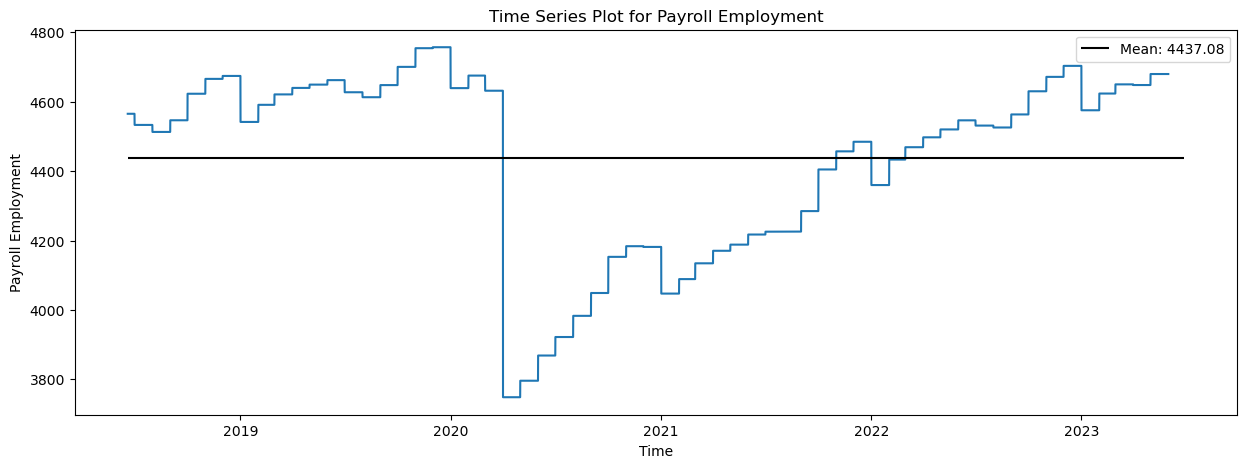

In [151]:
for variable in [x for x in clean_data.columns if x not in ["HourlyPrecipitation"]]:
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot()
    ax.plot(clean_data[variable])
    ax.set_title("Time Series Plot for {}".format(variable))
    ax.set_xlabel("Time")
    ax.set_ylabel(variable)
    # ax.hlines(y=clean_data[variable].mean(), xmin=2018, xmax=2024)
    ax.hlines(y=clean_data[variable].mean(), xmin=np.datetime64("2018-06-19"), xmax=np.datetime64("2023-06-29"), color="black", label="Mean: {:.2f}".format(clean_data[variable].mean()))
    ax.legend()
    plt.show()

    # sns.lineplot(x=clean_data.index, y=clean_data[variable])
    # plt.hlines(y=clean_data[variable].mean(), xmin=clean_data.index.min(), xmax=clean_data.index.max())

Time Series Decomposition Plots for those with Seasonality

In [74]:
display(clean_data.columns)

Index(['Energy Demand (MWH)', 'HourlyDewPointTemperature',
       'HourlyDryBulbTemperature', 'HourlyPrecipitation',
       'HourlyRelativeHumidity', 'HourlyStationPressure',
       'HourlyWetBulbTemperature', 'HourlyWindSpeed',
       'Energy Price (cents/KWH)', 'CPI-U', 'Unemployment Rate',
       'Unemployment Level', 'Employment Level', 'Labor Force Level',
       'Employment Population Ratio', 'Labor Force Participation',
       'Civilian Noninstitutional Population', 'Payroll Employment'],
      dtype='object')

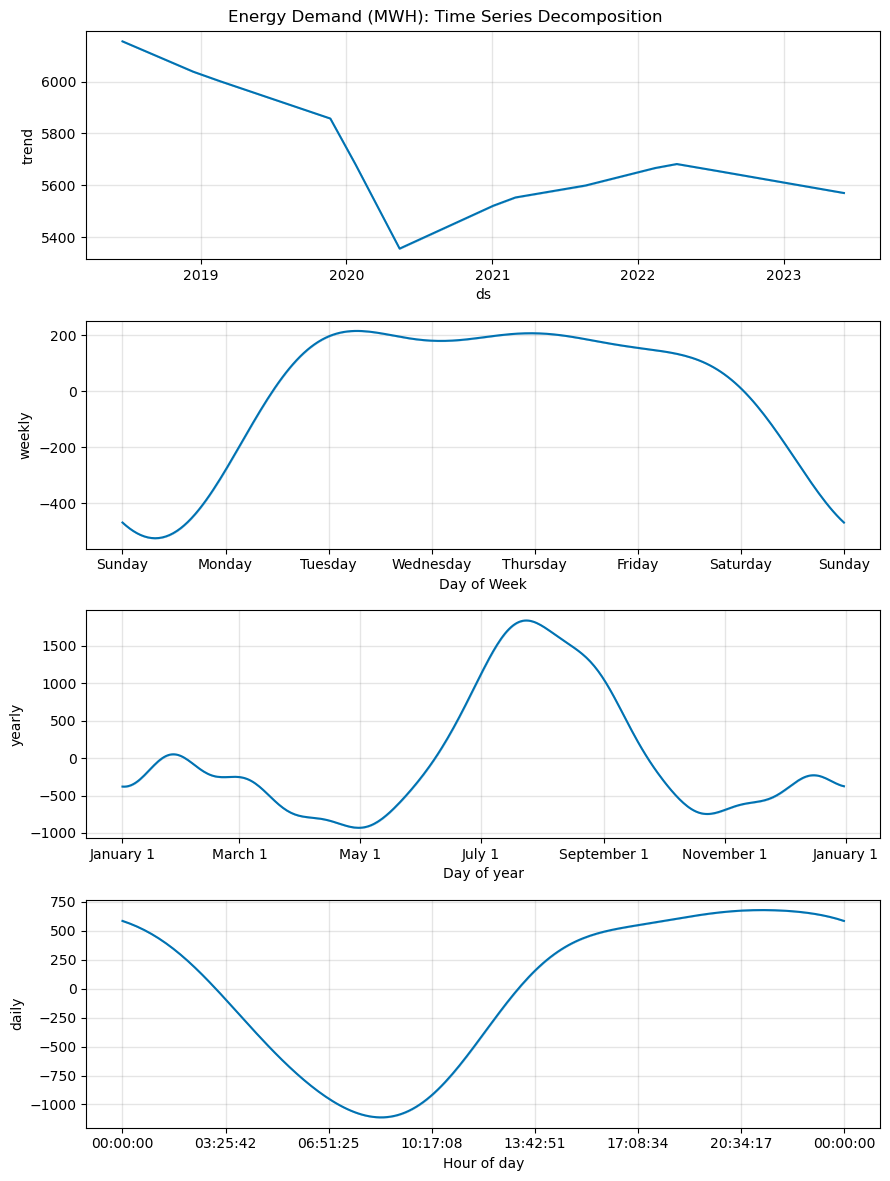

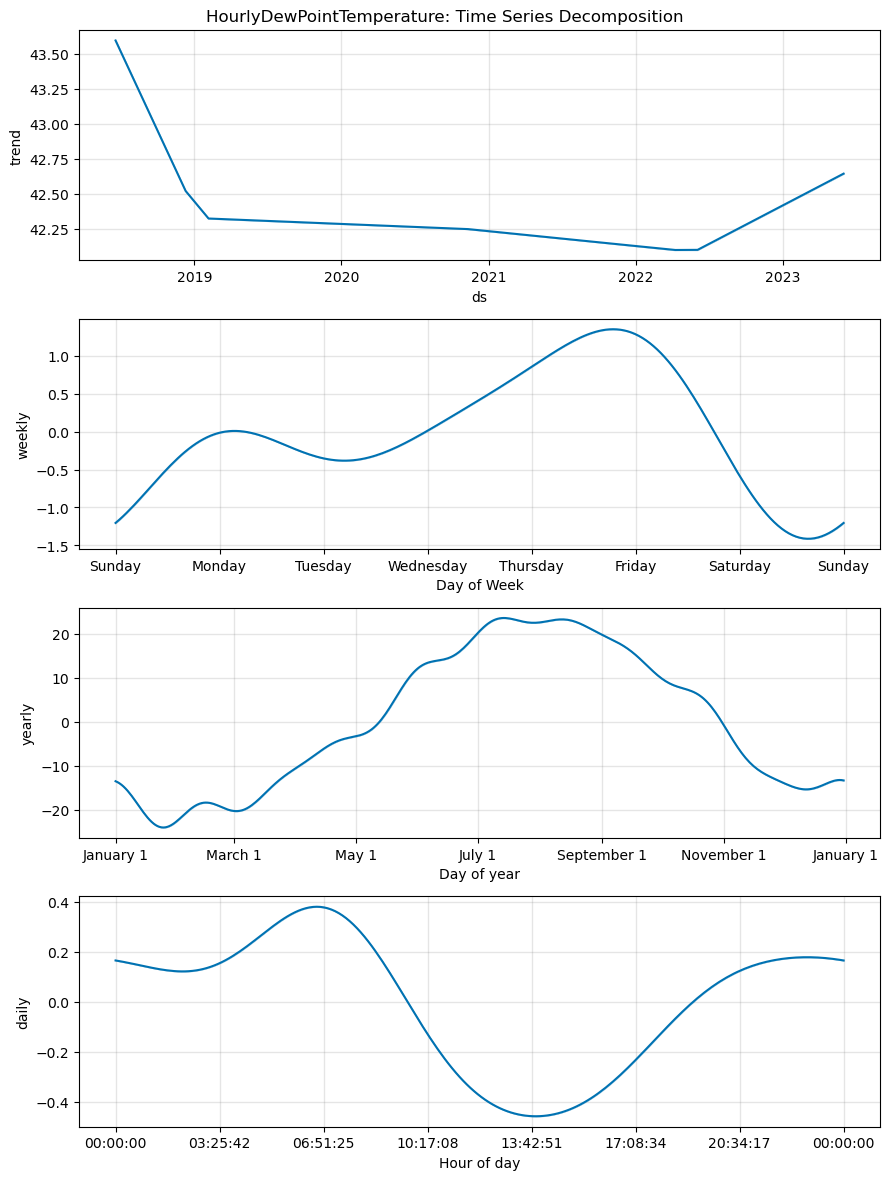

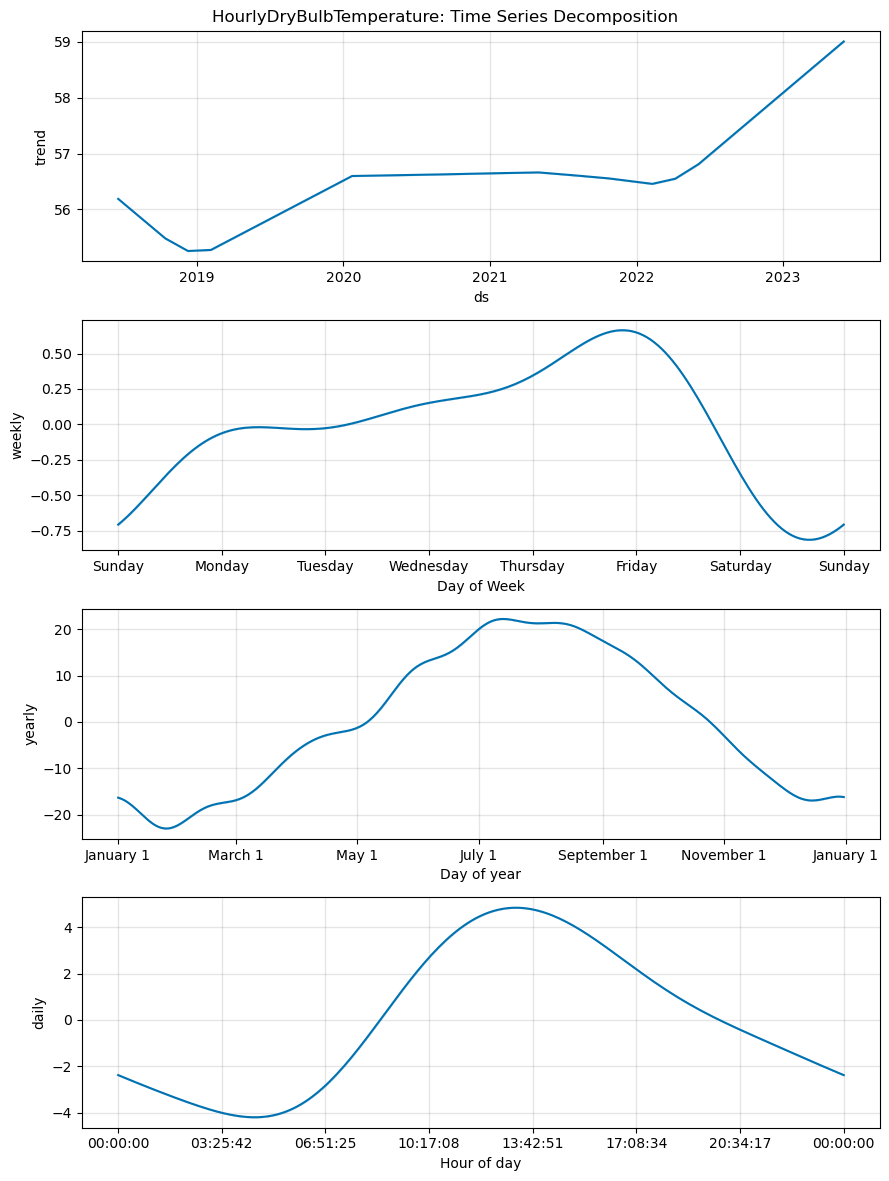

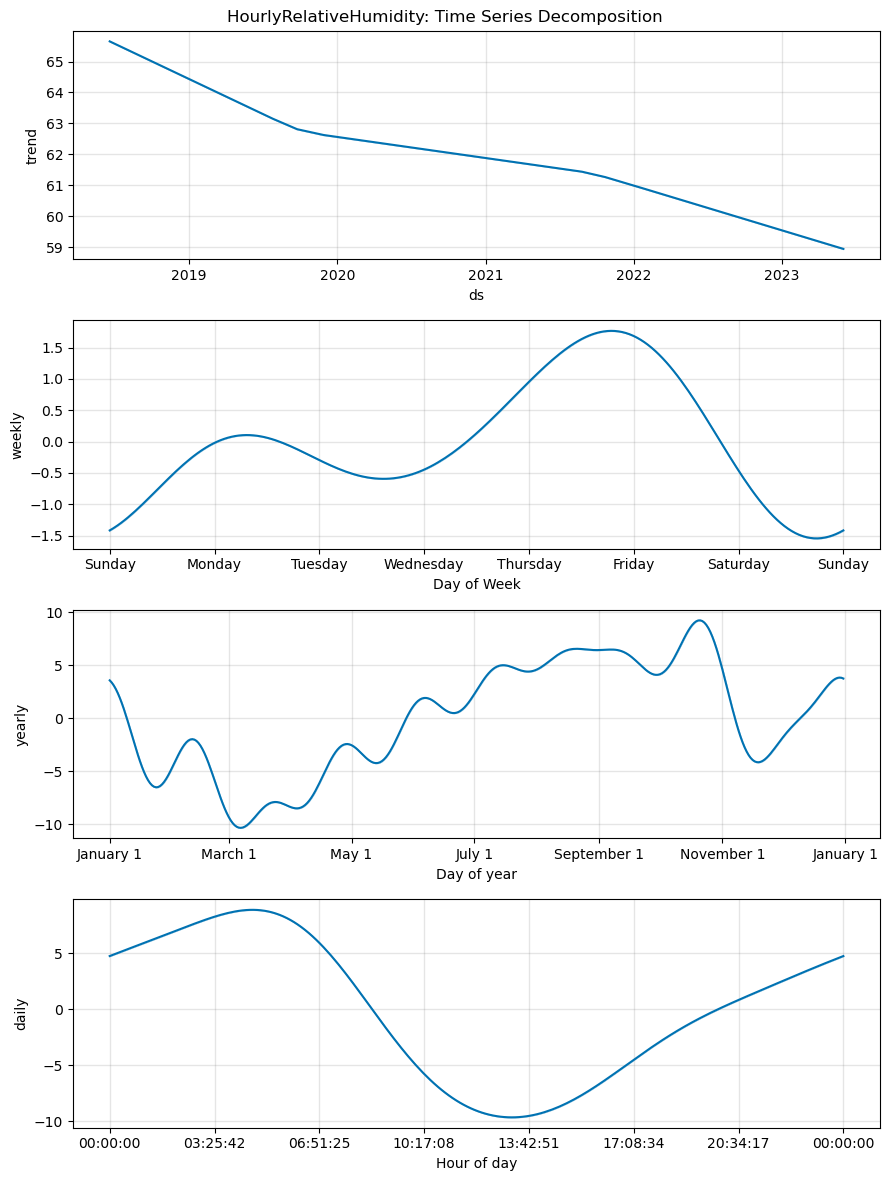

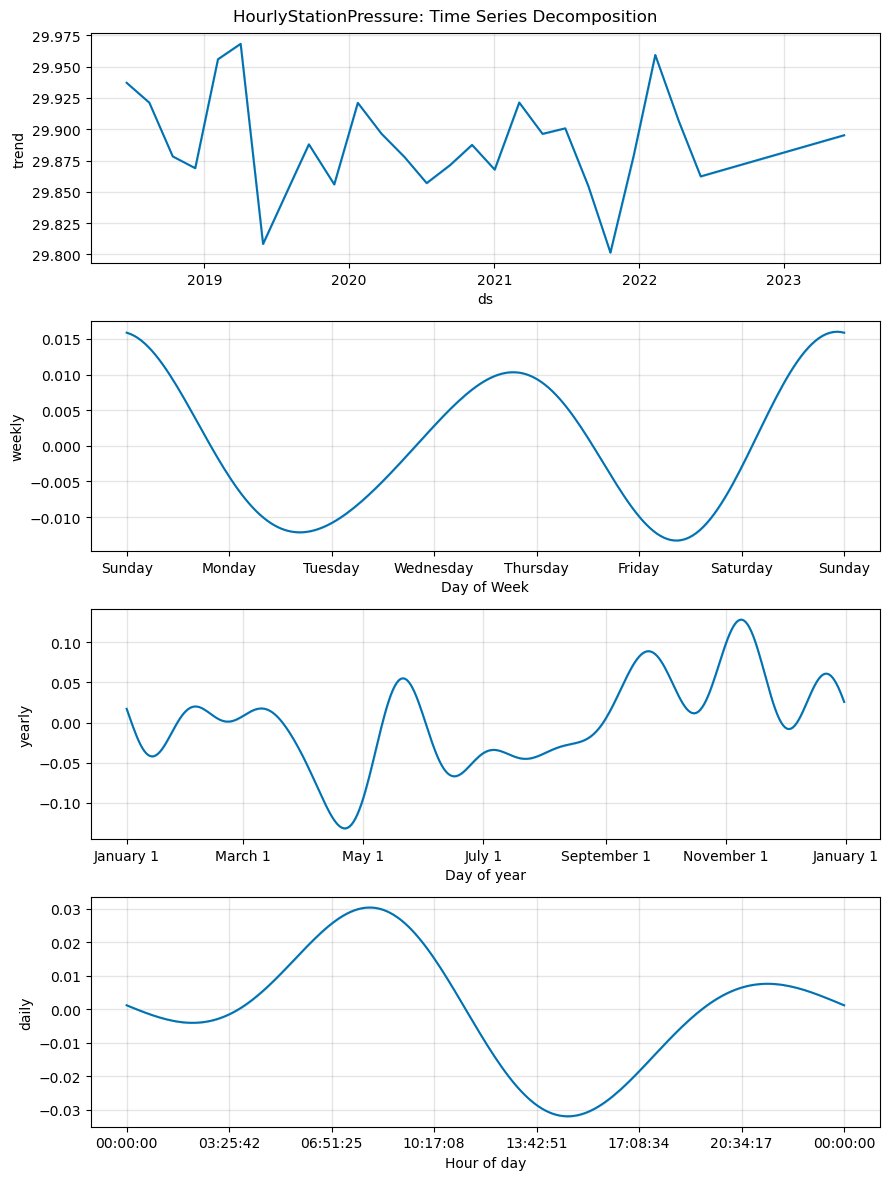

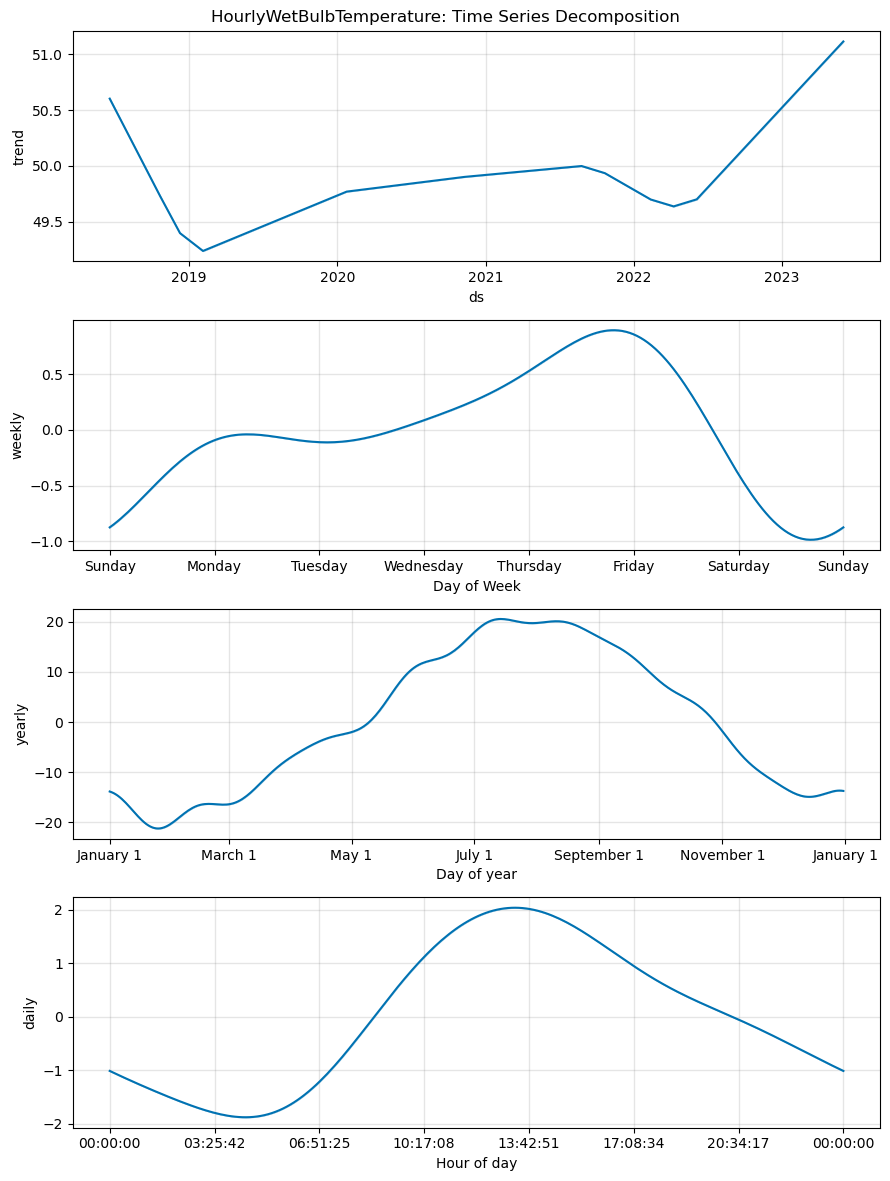

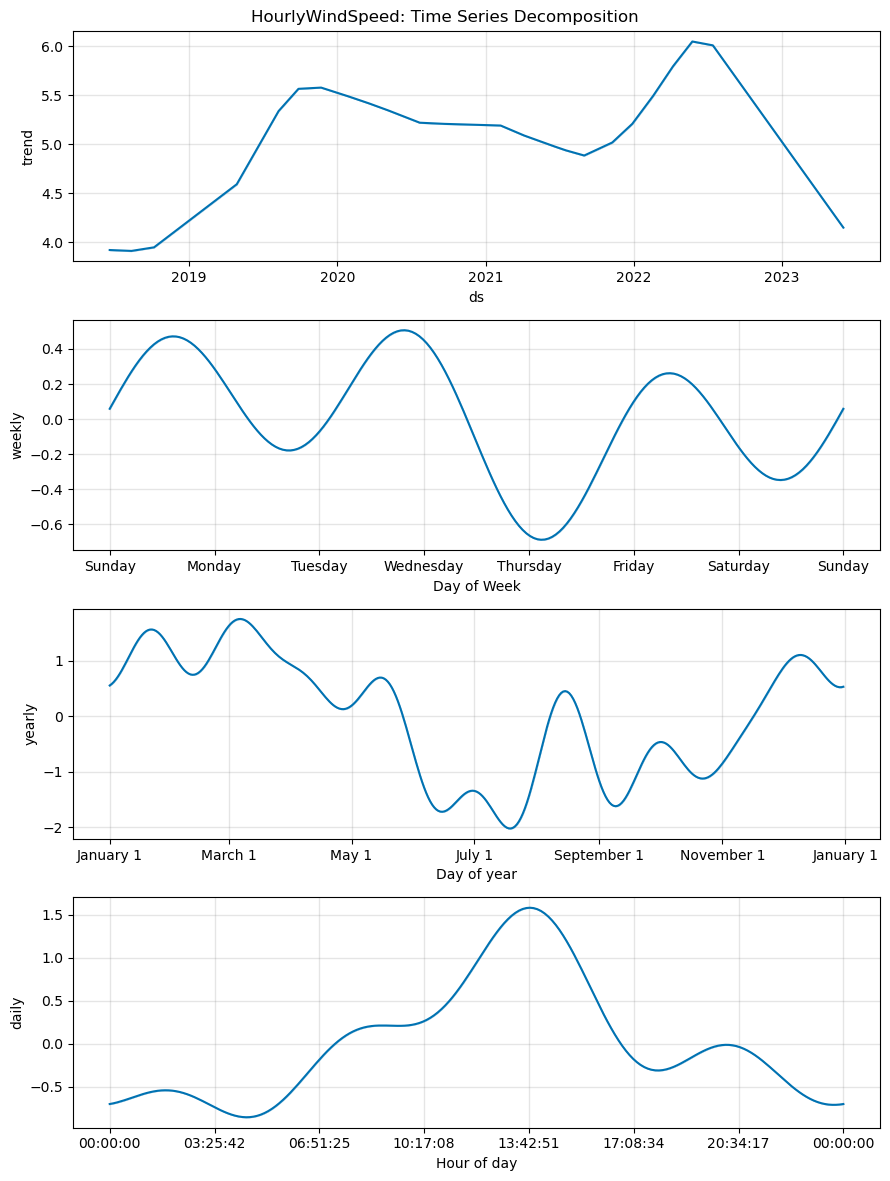

In [153]:
# for variable in clean_data.columns:
for variable in ["Energy Demand (MWH)", "HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyRelativeHumidity", "HourlyStationPressure", "HourlyWetBulbTemperature", "HourlyWindSpeed"]:
    fig = prophet_models[variable].plot_components(interpolations[variable])
    plt.suptitle(f"{variable}: Time Series Decomposition")
    plt.tight_layout()
    plt.show()

    yearly_data = 

In [ ]:
# display(forecasts)
residuals = forecasts["yhat"] - df["y"]
# display(residuals)

Text(0.5, 1.0, 'Correlations Between Variables')

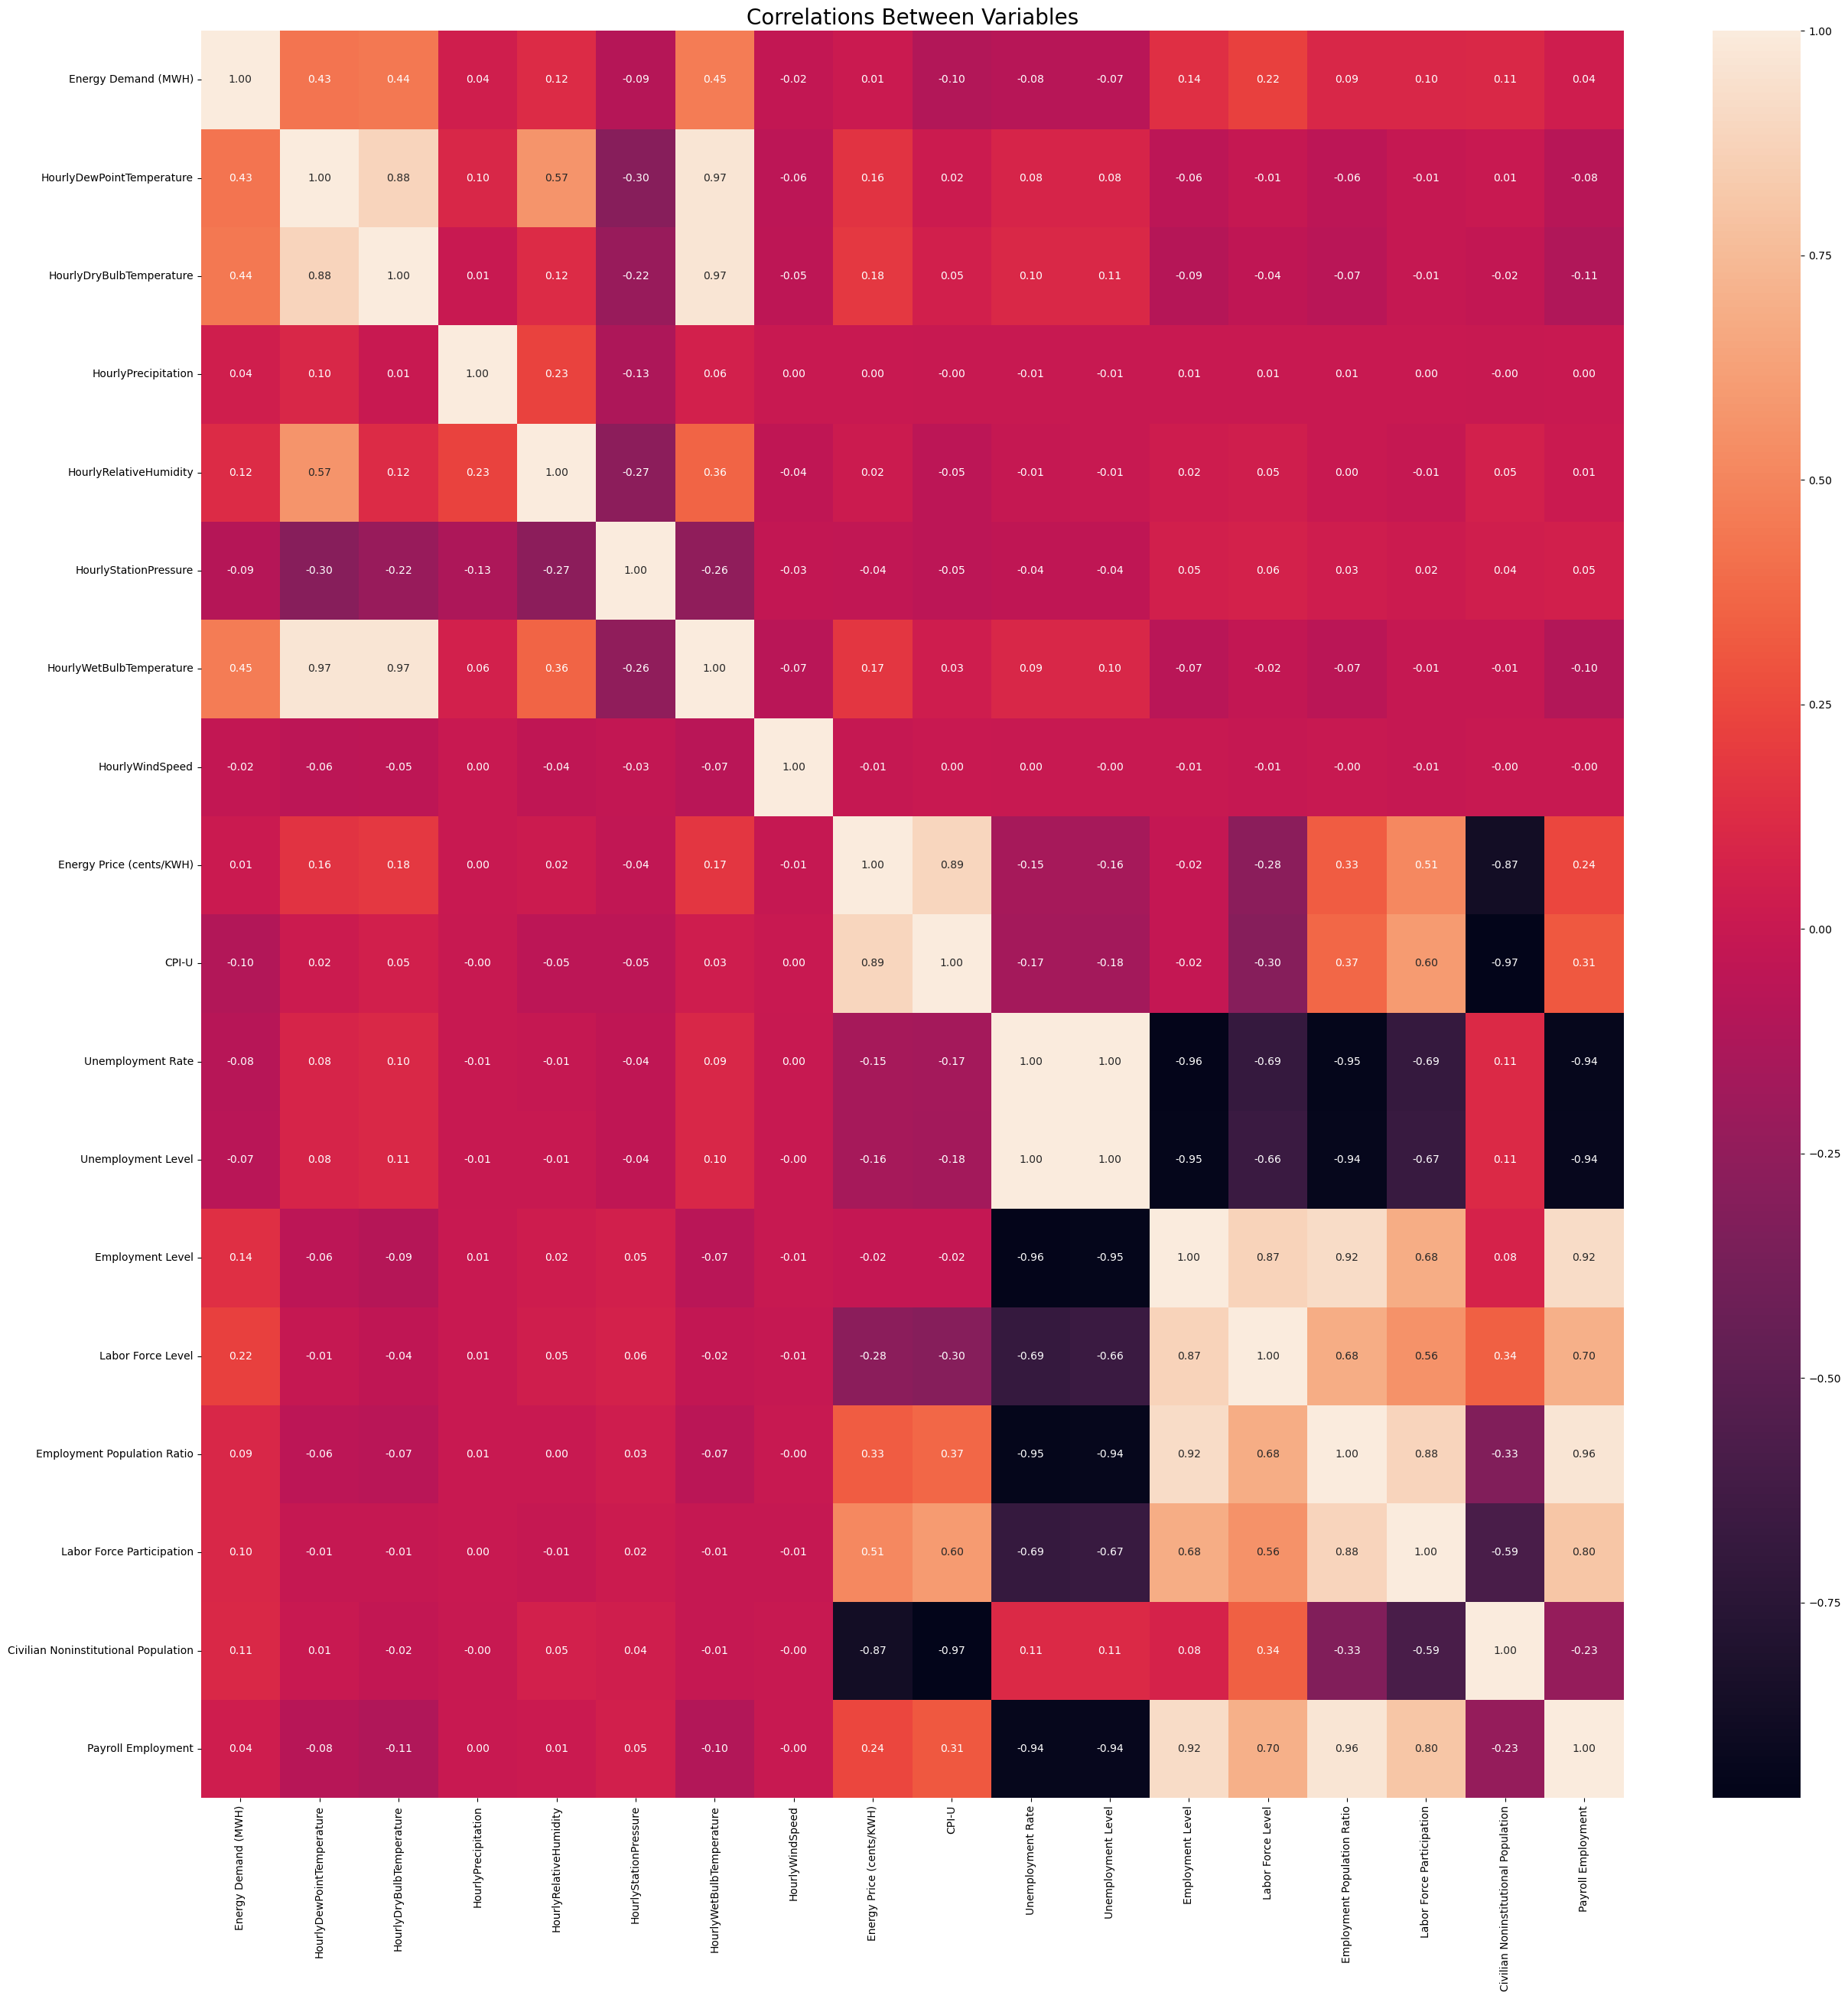

In [159]:
correlations = all_data.corr()
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot()
sns.heatmap(correlations, annot=True, fmt=".2f")
plt.fontsize=20
plt.title("Correlations Between Variables", size=20)

In [44]:
df = outliers_removed[["Energy Demand (MWH)"]].reset_index().rename(columns={"index":"ds", "Energy Demand (MWH)":"y"})
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True, 
        changepoint_prior_scale=0.001, seasonality_prior_scale=0.01)

results = model.fit(df)


21:29:45 - cmdstanpy - INFO - Chain [1] start processing
21:29:48 - cmdstanpy - INFO - Chain [1] done processing


0        215.056314
1        215.600432
2        215.374759
3        214.471616
4        212.984753
            ...    
44335     27.309903
44336     48.624674
44337     68.782133
44338     87.713058
44339    105.360926
Name: weekly, Length: 44340, dtype: float64

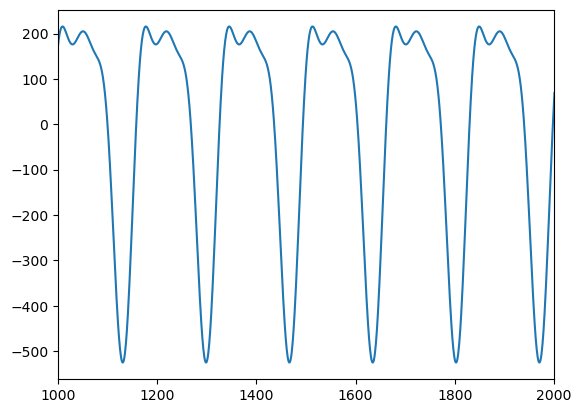

In [53]:
# prophet_models[variable] = model
interpolated_values = model.predict(df)
# interpolations[variable] = interpolated_values
# to_impute = outliers_removed[variable].isna().values
# clean_data.loc[to_impute, variable] = interpolated_values["yhat"][to_impute].values
# plt.plot(interpolated_values["yearly"])
plt.plot(interpolated_values["weekly"])
plt.xlim(1000, 2000)
display(interpolated_values["weekly"])

21:23:10 - cmdstanpy - INFO - Chain [1] start processing
21:23:10 - cmdstanpy - INFO - Chain [1] done processing
/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/prophet/plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/prophet/plot.py:349: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/prophet/plot.py:352: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python

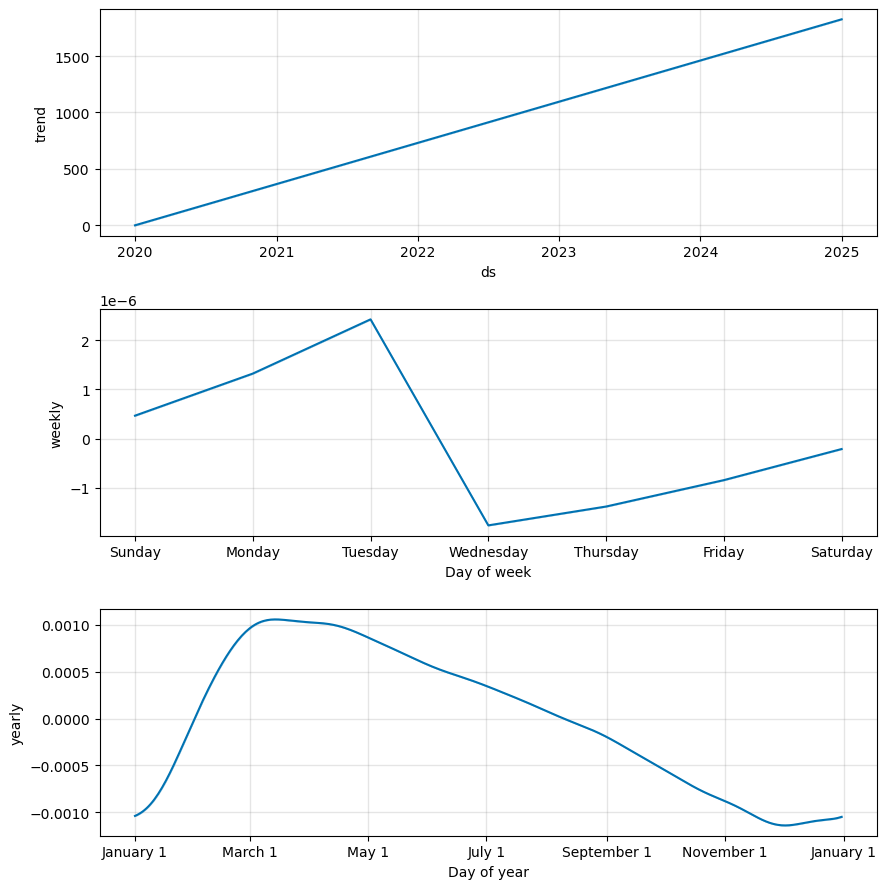

In [41]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Example data
df = pd.DataFrame({
    'ds': pd.date_range(start='2020-01-01', end='2024-01-01', freq='D'),
})
df['y'] = range(df.shape[0])

# Create and fit Prophet model
model = Prophet(seasonality_mode='additive')
model.fit(df)

# Make future dataframe for predictions
future = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future)

# Plot the yearly seasonal component
fig = model.plot_components(forecast)
plt.show()


In [43]:
display(model.predict(df=df))

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0    2020-01-01     0.002019    -0.002996     0.005024     0.002019   
1    2020-01-02     1.001946     0.996962     1.004625     1.001946   
2    2020-01-03     2.001873     1.996953     2.004779     2.001873   
3    2020-01-04     3.001800     2.997109     3.004512     3.001800   
4    2020-01-05     4.001727     3.996652     4.004395     4.001727   
...         ...          ...          ...          ...          ...   
1457 2023-12-28  1457.000991  1456.996227  1457.004049  1457.000991   
1458 2023-12-29  1458.000999  1457.996348  1458.003851  1458.000999   
1459 2023-12-30  1459.001008  1458.996165  1459.003757  1459.001008   
1460 2023-12-31  1460.001016  1459.995905  1460.003623  1460.001016   
1461 2024-01-01  1461.001025  1460.996186  1461.003851  1461.001025   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0        0.002019       -0.001046             -0.001046             -0.001046   
1        1.001946       -0.001037             -0.001037             -0.001037   
2        2.001873       -0.001027             -0.001027             -0.001027   
3        3.001800       -0.001015             -0.001015             -0.001015   
4        4.001727       -0.001001             -0.001001             -0.001001   
...           ...             ...                   ...                   ...   
1457  1457.000991       -0.001068             -0.001068             -0.001068   
1458  1458.000999       -0.001063             -0.001063             -0.001063   
1459  1459.001008       -0.001058             -0.001058             -0.001058   
1460  1460.001016       -0.001051             -0.001051             -0.001051   
1461  1461.001025       -0.001043             -0.001043             -0.001043   

            weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0    -1.765086e-06 -1.765086e-06 -1.765086e-06 -0.001044     -0.001044   
1    -1.382229e-06 -1.382229e-06 -1.382229e-06 -0.001036     -0.001036   
2    -8.456414e-07 -8.456414e-07 -8.456414e-07 -0.001026     -0.001026   
3    -2.132988e-07 -2.132988e-07 -2.132988e-07 -0.001015     -0.001015   
4     4.643110e-07  4.643110e-07  4.643110e-07 -0.001001     -0.001001   
...            ...           ...           ...       ...           ...   
1457 -1.382229e-06 -1.382229e-06 -1.382229e-06 -0.001066     -0.001066   
1458 -8.456414e-07 -8.456414e-07 -8.456414e-07 -0.001062     -0.001062   
1459 -2.132988e-07 -2.132988e-07 -2.132988e-07 -0.001057     -0.001057   
1460  4.643110e-07  4.643110e-07  4.643110e-07 -0.001051     -0.001051   
1461  1.319763e-06  1.319763e-06  1.319763e-06 -0.001044     -0.001044   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0        -0.001044                   0.0                         0.0   
1        -0.001036                   0.0                         0.0   
2        -0.001026                   0.0                         0.0   
3        -0.001015                   0.0                         0.0   
4        -0.001001                   0.0                         0.0   
...            ...                   ...                         ...   
1457     -0.001066                   0.0                         0.0   
1458     -0.001062                   0.0                         0.0   
1459     -0.001057                   0.0                         0.0   
1460     -0.001051                   0.0                         0.0   
1461     -0.001044                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
0                            0.0     0.000973  
1                            0.0     1.000909  
2                            0.0     2.000846  
3                            0.0     3.000785  
4                            0.0     4.000726  
...                          ...          ...  
1457                         0.0  1456.999923  
1458                         0.0  1457.999936  
1